In [139]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import default_style
# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
DATA_FOLDER = 'dataset'
IMAGE_FOLDER = 'images'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [141]:
df = pd.read_csv(DATASET)

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,1st,actor_1,M
1,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
3,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
4,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [142]:
TARGET_COLUMN = 'vocal_channel'

In [143]:
values = df[TARGET_COLUMN].unique().tolist()
values

['speech', 'song']

In [144]:
one_hot = pd.get_dummies(df[TARGET_COLUMN])
df = df.join(one_hot)
df = df.drop([TARGET_COLUMN], axis=1)

In [145]:
def plot_percentage(data, columns):
    ones_percentage = [data[col].mean() * 100 for col in columns]

    plt.figure(figsize=default_style.FULLSIZE_FIGURE)
    plt.bar(columns, ones_percentage)
    plt.xlabel('Columns')
    plt.ylabel('Percentage of ones')
    plt.title('Percentage of ones in each column')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.yticks(range(0, 101, 10))  # increments of 10 along the y-axis
    plt.show()

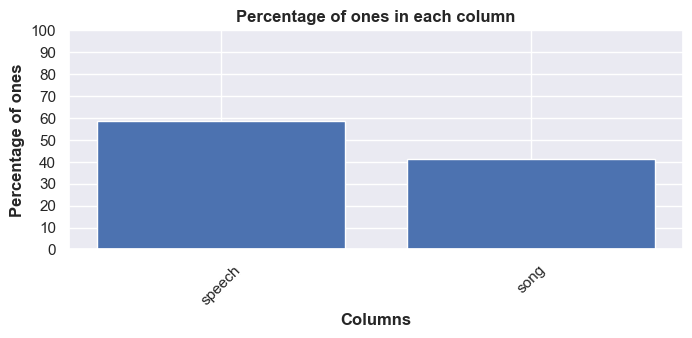

In [146]:
plot_percentage(df, values)

## Visualize the target class

In [147]:
TARGET_CLASS = 'song'

In [148]:
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler

def isomap_by_class(data, values_list, value):

    data2 = data.drop(values_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    isomap = Isomap(n_components=2)
    embedding = isomap.fit_transform(X_scaled)

    plt.figure(figsize=default_style.FULLSIZE_FIGURE)
    plt.scatter(embedding[:, 0], embedding[:, 1], s=15,c=data[value], cmap='viridis')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.title(f'Scatterplot of {value} attribute using Isomap')
    plt.show()

In [149]:
from sklearn.decomposition import PCA

def pca_by_class(data, values_list, value):

    data2 = data.drop(values_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    pca = PCA(n_components=2)
    embedding = pca.fit_transform(X_scaled)

    plt.figure(figsize=default_style.FULLSIZE_FIGURE)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=data[value],s=15, cmap='viridis')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.title(f'Scatterplot of {value} attribute using PCA')
    plt.show()

In [150]:
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

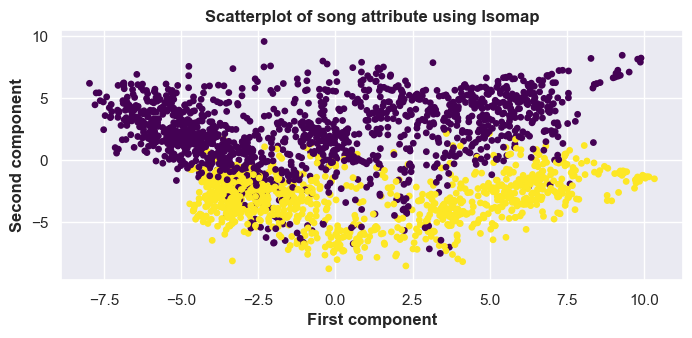

In [151]:
isomap_by_class(df[numerical_attr_list], values, TARGET_CLASS)

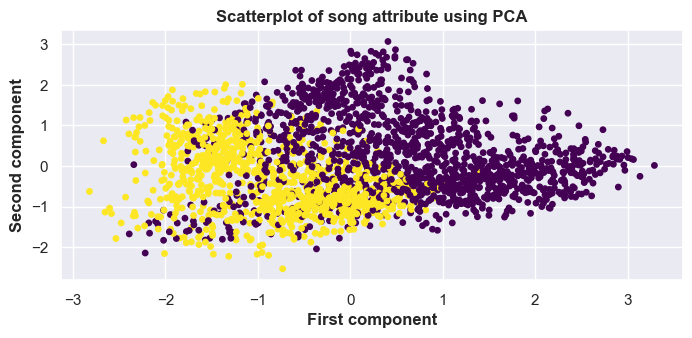

In [152]:
pca_by_class(df[numerical_attr_list], values, TARGET_CLASS)

## Dataset imbalance

In [153]:
from sklearn.model_selection import train_test_split

split_index = df.index[df['actor'] == 'actor_19'][0]

df_train = df[:split_index]
df_test = df[split_index:]

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train, df_valid = train_test_split(df_train, test_size = 0.2, random_state = 100)




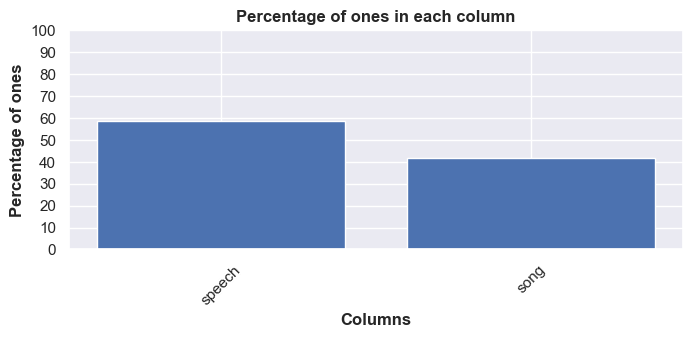

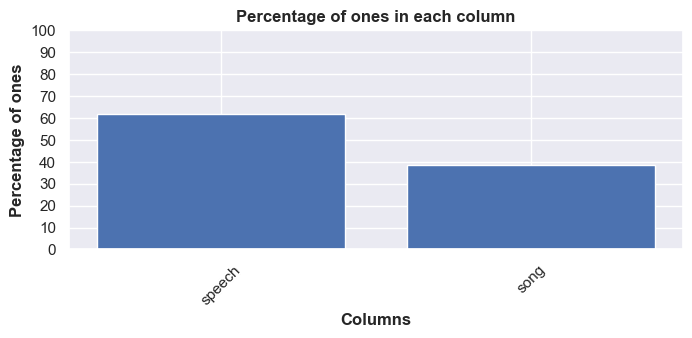

In [154]:
plot_percentage(df_train, values)
plot_percentage(df_valid, values)

# Dataset preparation

In [155]:
target_train = df_train[TARGET_CLASS]
target_valid = df_valid[TARGET_CLASS]
target_test = df_test[TARGET_CLASS]

display(df_train.shape, df_valid.shape, df_test.shape)

(1449, 251)

(363, 251)

(617, 251)

In [156]:
excluded_prefixes = ['zc']
columns_to_keep = []

for column in df[numerical_attr_list].drop(values, axis=1).columns:
    if not column.startswith(tuple(excluded_prefixes)) and column != TARGET_COLUMN:
        columns_to_keep.append(column)

# selected features without target
columns_to_keep

['frame_count',
 'sum',
 'mean',
 'std',
 'min',
 'max',
 'q01',
 'q05',
 'q25',
 'q75',
 'q95',
 'q99',
 'kur',
 'skew',
 'lag1_q25',
 'lag1_q75',
 'lag1_skew',
 'mfcc_sum',
 'mfcc_mean',
 'mfcc_std',
 'mfcc_min',
 'mfcc_max',
 'mfcc_q01',
 'mfcc_q05',
 'mfcc_q25',
 'mfcc_q50',
 'mfcc_q75',
 'mfcc_q95',
 'mfcc_q99',
 'mfcc_kur',
 'mfcc_skew',
 'sc_sum',
 'sc_mean',
 'sc_std',
 'sc_min',
 'sc_max',
 'sc_q01',
 'sc_q05',
 'sc_q25',
 'sc_q50',
 'sc_q75',
 'sc_q95',
 'sc_q99',
 'sc_kur',
 'sc_skew',
 'stft_sum',
 'stft_mean',
 'stft_std',
 'stft_min',
 'stft_q01',
 'stft_q05',
 'stft_q25',
 'stft_q50',
 'stft_q75',
 'stft_kur',
 'stft_skew',
 'length_w1',
 'sum_w1',
 'std_w1',
 'q05_w1',
 'kur_w1',
 'skew_w1',
 'lag1_sum_w1',
 'lag1_max_w1',
 'lag1_q95_w1',
 'lag1_kur_w1',
 'lag1_skew_w1',
 'mfcc_sum_w1',
 'mfcc_mean_w1',
 'mfcc_std_w1',
 'mfcc_min_w1',
 'mfcc_max_w1',
 'mfcc_q05_w1',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'mfcc_q75_w1',
 'mfcc_q95_w1',
 'mfcc_q99_w1',
 'mfcc_kur_w1',
 'mfcc_sk

In [157]:
df_train = df_train.drop(df_train.columns.difference(columns_to_keep), axis=1)
df_valid = df_valid.drop(df_valid.columns.difference(columns_to_keep), axis=1)
df_test = df_test.drop(df_test.columns.difference(columns_to_keep), axis=1)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [158]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train)
X_valid = scaler.fit_transform(df_valid)
X_test = scaler.fit_transform(df_test)

y_train = target_train.to_numpy()
y_valid = target_valid.to_numpy()
y_test = target_test.to_numpy()

In [159]:
X_res_t = X_train
y_res_t = y_train
X_res_v = X_valid
y_res_v = y_valid




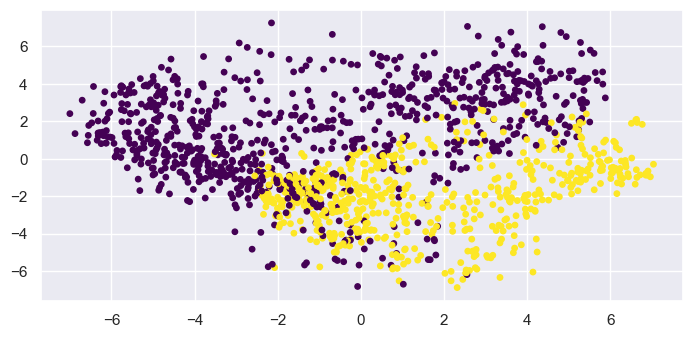

In [160]:
isomap = Isomap(n_components=2, n_neighbors=10)
embedding = isomap.fit_transform(X_res_t)

plt.figure(figsize=default_style.FULLSIZE_FIGURE)
plt.scatter(embedding[:, 0], embedding[:, 1], s=15, c=y_res_t, cmap='viridis')
plt.show()

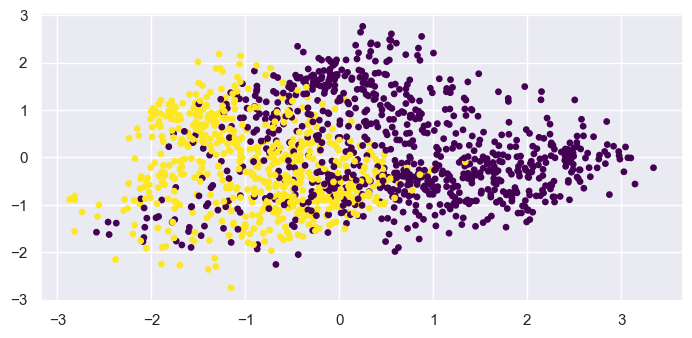

In [161]:
pca = PCA(n_components=2)
embedding = pca.fit_transform(X_res_t)

plt.figure(figsize=default_style.FULLSIZE_FIGURE)
plt.scatter(embedding[:, 0], embedding[:, 1], s=15, c=y_res_t, cmap='viridis')
plt.show()

# Logistic Regression

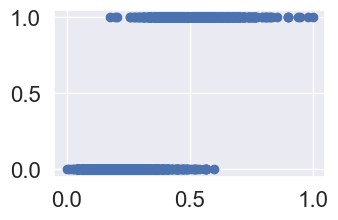

In [162]:
plt.scatter(X_res_t.T[0], y_res_t)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [163]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [164]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['none', 'elasticnet', 'l1', 'l2'])
    C = trial.suggest_float('C', 0.001,10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg',  'sag', 'saga'])
    

    logr = LogisticRegression(solver=solver, penalty=penalty, C=C)

    logr.fit(X_res_t, y_res_t)
    y_pred = logr.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError, TypeError))

[I 2023-07-06 19:30:50,404] A new study created in memory with name: no-name-02bc98e9-5cf4-4699-8dc3-4d343574df8e
[W 2023-07-06 19:30:50,404] Trial 0 failed with parameters: {'penalty': 'elasticnet', 'C': 2.875844859052055, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualen

[W 2023-07-06 19:30:50,474] Trial 6 failed with value None.
[W 2023-07-06 19:30:50,493] Trial 8 failed with value None.
[W 2023-07-06 19:30:50,502] Trial 12 failed with parameters: {'penalty': 'elasticnet', 'C': 3.5690207549054445, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu

[W 2023-07-06 19:30:51,000] Trial 23 failed with value None.
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2023-07-06 19:30:51,016] Trial 3 finished with value: 0.9559228650137741 and parameters: {'penalty': 'none', 'C': 1.8950823804714716, 'solver': 'newton-cg'}. Best is trial 7 with value: 0.9807162534435262.
[W 2023-07-06 19:30:51,020] Trial 25 failed with parameters: {'penalty': 'elasticnet', 'C': 9.424671713842214, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  F

[W 2023-07-06 19:30:51,212] Trial 32 failed with value None.
[W 2023-07-06 19:30:51,214] Trial 33 failed with parameters: {'penalty': 'l1', 'C': 2.8539807608704093, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py"

[W 2023-07-06 19:30:51,438] Trial 40 failed with value None.
[W 2023-07-06 19:30:51,452] Trial 41 failed with parameters: {'penalty': 'elasticnet', 'C': 4.894814067141284, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_mod

[W 2023-07-06 19:30:51,558] Trial 48 failed with parameters: {'penalty': 'elasticnet', 'C': 4.5212499349148265, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 64, in _check_solver
    raise ValueE

[W 2023-07-06 19:30:51,651] Trial 54 failed with parameters: {'penalty': 'elasticnet', 'C': 5.110750160958731, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 64, in _check_solver
    raise ValueEr

[W 2023-07-06 19:30:51,731] Trial 61 failed with parameters: {'penalty': 'elasticnet', 'C': 4.651181406027955, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 64, in _check_solver
    raise ValueEr

[W 2023-07-06 19:30:51,805] Trial 64 failed with value None.
[W 2023-07-06 19:30:51,825] Trial 69 failed with parameters: {'penalty': 'elasticnet', 'C': 4.720803609311066, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_mod

[W 2023-07-06 19:30:51,939] Trial 72 failed with value None.
[W 2023-07-06 19:30:51,951] Trial 77 failed with parameters: {'penalty': 'elasticnet', 'C': 4.627188557195782, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_mod

[W 2023-07-06 19:30:52,032] Trial 85 failed with parameters: {'penalty': 'elasticnet', 'C': 4.1964088858843995, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 64, in _check_solver
    raise ValueE

[W 2023-07-06 19:30:52,104] Trial 92 failed with parameters: {'penalty': 'elasticnet', 'C': 4.506813419713926, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 64, in _check_solver
    raise ValueEr

[W 2023-07-06 19:30:52,205] Trial 97 failed with value None.
[W 2023-07-06 19:30:52,214] Trial 98 failed with value None.
[W 2023-07-06 19:30:52,233] Trial 102 failed with parameters: {'penalty': 'elasticnet', 'C': 4.770116892910696, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\

[W 2023-07-06 19:30:52,320] Trial 104 failed with value None.
[W 2023-07-06 19:30:52,320] Trial 109 failed with parameters: {'penalty': 'elasticnet', 'C': 5.067149641162155, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_mo

[W 2023-07-06 19:30:52,404] Trial 117 failed with parameters: {'penalty': 'elasticnet', 'C': 4.4178086292052, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueErro

[W 2023-07-06 19:30:52,482] Trial 119 failed with value None.
[W 2023-07-06 19:30:52,489] Trial 125 failed with parameters: {'penalty': 'elasticnet', 'C': 4.632442712773874, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_mo

[W 2023-07-06 19:30:52,568] Trial 132 failed with parameters: {'penalty': 'elasticnet', 'C': 4.601107502080373, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueEr

[W 2023-07-06 19:30:52,639] Trial 135 failed with value None.
[W 2023-07-06 19:30:52,648] Trial 140 failed with parameters: {'penalty': 'elasticnet', 'C': 4.253465891240701, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_mo

[W 2023-07-06 19:30:52,719] Trial 143 failed with value None.
[W 2023-07-06 19:30:52,724] Trial 148 failed with parameters: {'penalty': 'elasticnet', 'C': 4.573799683935934, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\linear_mo

In [165]:
best_params = study.best_params

logr = LogisticRegression(**best_params)
logr.fit(X_res_t.T[0].reshape(-1,1), y_res_t)

y_pred_test = logr.predict(X_test.T[0].reshape(-1,1))


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 4.788347658399181, 'solver': 'liblinear'}
              precision    recall  f1-score   support

       False       0.99      0.84      0.91       355
        True       0.82      0.99      0.89       262

    accuracy                           0.90       617
   macro avg       0.90      0.91      0.90       617
weighted avg       0.92      0.90      0.90       617

Accuracy 0.9011345218800648
F1-score [0.90687023 0.89464594]


choose liblinear solver beacause for small datasets is a good choice. 
The key difference between these l1(ridege) and l2(lasso) is that Lasso shrinks the less 
important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

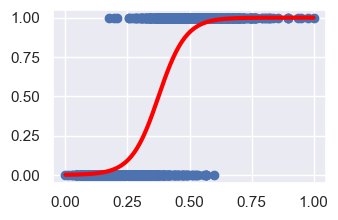

In [166]:
from scipy.special import expit



loss = expit(sorted(X_test.T[0].reshape(-1,1)) *logr.coef_.T[0] + logr.intercept_).ravel()
plt.plot(sorted(X_test.T[0].reshape(-1,1)), loss, color='red', linewidth=3)
plt.scatter(X_res_t.T[0].reshape(-1,1), y_res_t)
#plt.xlabel(selected_columns[0], fontsize=16)
#plt.ylabel('Occupancy', fontsize=16)
plt.tick_params(axis='both', which='major')
plt.show()

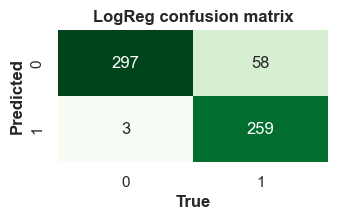

In [167]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False, fmt=".4g")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LogReg confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'LogReg_conf_matrix.pdf'), format='pdf')
plt.show()

C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2622033282.py:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(IMAGE_FOLDER, 'LogReg_ROC.pdf'), format='pdf')
C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2622033282.py:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(IMAGE_FOLDER, 'LogReg_ROC.pdf'), format='pdf')
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


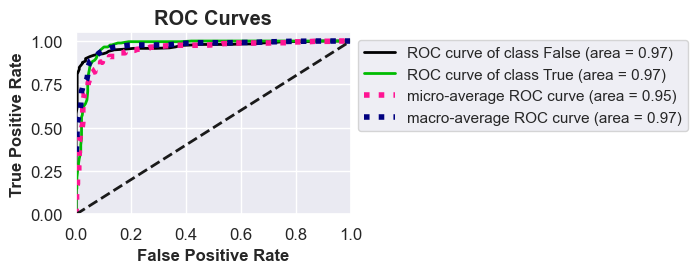

0.9694925276851951


In [168]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

y_test_pred_proba = logr.predict_proba(X_test.T[0].reshape(-1,1))
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'LogReg_ROC.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


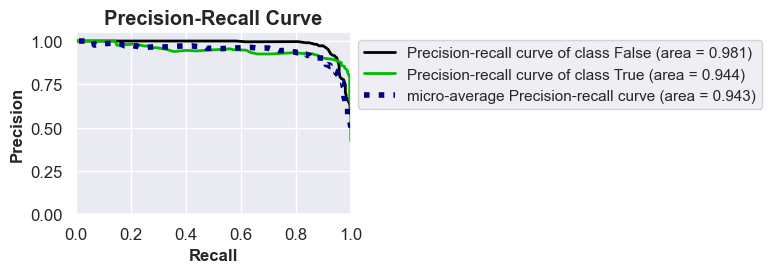

In [169]:
from scikitplot.metrics import plot_precision_recall

plot_precision_recall(y_test, logr.predict_proba(X_test.T[0].reshape(-1,1)))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# Suppport Vector Machine

In [170]:
pca = PCA(n_components=2)
pca.fit(X_res_t)
X_pca = pca.transform(X_res_t)

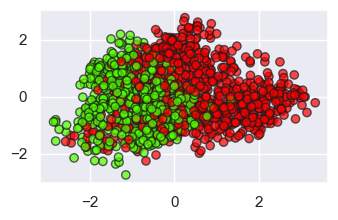

In [171]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

## Linear SVM

In [172]:
from sklearn.svm import LinearSVC

In [173]:
# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01,100)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    

    lin_svc = LinearSVC(loss=loss, penalty=penalty, C=C)

    lin_svc.fit(X_res_t, y_res_t)
    y_pred = lin_svc.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-07-06 19:30:57,574] A new study created in memory with name: no-name-34bd4fd7-66b6-46a5-8c6c-4f181a26ff74
[W 2023-07-06 19:30:57,587] Trial 0 failed with parameters: {'penalty': 'l1', 'C': 49.18944739442345, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^

[W 2023-07-06 19:30:57,675] Trial 12 failed with value None.
[W 2023-07-06 19:30:57,693] Trial 13 failed with parameters: {'penalty': 'l1', 'C': 50.41158756205205, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HU

[W 2023-07-06 19:30:57,820] Trial 17 failed with value None.
[W 2023-07-06 19:30:57,836] Trial 19 failed with value None.
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-06 19:30:57,851] Trial 14 finished with value: 0.9476584022038568 and parameters: {'penalty': 'l2', 'C': 87.42225971940711, 'loss': 'squared_hinge'}. Best is trial 1 with value: 0.9641873278236914.
[W 2023-07-06 19:30:57,857] Trial 24 failed with parameters: {'penalty': 'l1', 'C': 38.80706670157822, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_

[W 2023-07-06 19:30:57,986] Trial 32 failed with parameters: {'penalty': 'l1', 'C': 6.402894476574428, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packa

[W 2023-07-06 19:30:58,074] Trial 37 failed with parameters: {'penalty': 'l1', 'C': 3.9139094572143067, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_base.py", line 1223, i

[W 2023-07-06 19:30:58,135] Trial 40 failed with value None.
[W 2023-07-06 19:30:58,146] Trial 42 failed with parameters: {'penalty': 'l1', 'C': 1.6459850838920147, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-H

[W 2023-07-06 19:30:58,214] Trial 43 failed with value None.
[W 2023-07-06 19:30:58,221] Trial 48 failed with parameters: {'penalty': 'l1', 'C': 2.902530542332461, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HU

[W 2023-07-06 19:30:58,320] Trial 54 failed with parameters: {'penalty': 'l1', 'C': 1.7306929612548254, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_base.py", line 1223, i

[W 2023-07-06 19:30:58,389] Trial 60 failed with parameters: {'penalty': 'l1', 'C': 1.796520358637709, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_base.py", line 1223, in

[W 2023-07-06 19:30:58,456] Trial 62 failed with value None.
[W 2023-07-06 19:30:58,468] Trial 66 failed with parameters: {'penalty': 'l1', 'C': 2.804291758309823, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HU

[W 2023-07-06 19:30:58,566] Trial 71 failed with parameters: {'penalty': 'l1', 'C': 0.6852095733608508, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_base.py", line 1223, i

[W 2023-07-06 19:30:58,634] Trial 74 failed with value None.
[W 2023-07-06 19:30:58,654] Trial 78 failed with parameters: {'penalty': 'l1', 'C': 2.3566203868483186, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-H

[W 2023-07-06 19:30:58,715] Trial 81 failed with value None.
[W 2023-07-06 19:30:58,716] Trial 84 failed with parameters: {'penalty': 'l1', 'C': 0.11569176325181019, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-

[W 2023-07-06 19:30:58,773] Trial 86 failed with value None.
[W 2023-07-06 19:30:58,775] Trial 87 failed with value None.
[W 2023-07-06 19:30:58,775] Trial 90 failed with parameters: {'penalty': 'l1', 'C': 0.9057940323492967, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                       

[W 2023-07-06 19:30:58,836] Trial 91 failed with value None.
[W 2023-07-06 19:30:58,836] Trial 92 failed with value None.
[W 2023-07-06 19:30:58,836] Trial 96 failed with parameters: {'penalty': 'l1', 'C': 0.11475773554150792, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                      

[W 2023-07-06 19:30:58,921] Trial 98 failed with value None.
[W 2023-07-06 19:30:58,921] Trial 102 failed with parameters: {'penalty': 'l1', 'C': 2.722418199724002, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-H

[W 2023-07-06 19:30:58,997] Trial 104 failed with value None.
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2023-07-06 19:30:59,012] Trial 109 failed with parameters: {'penalty': 'l1', 'C': 0.29054011874263175, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm

[W 2023-07-06 19:30:59,080] Trial 114 failed with parameters: {'penalty': 'l1', 'C': 0.7056323555697028, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_base.py", line 1223, 

[W 2023-07-06 19:30:59,143] Trial 118 failed with value None.
[W 2023-07-06 19:30:59,149] Trial 119 failed with parameters: {'penalty': 'l1', 'C': 3.0982438289745318, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2

[W 2023-07-06 19:30:59,193] Trial 119 failed with value None.
[W 2023-07-06 19:30:59,195] Trial 126 failed with parameters: {'penalty': 'l1', 'C': 3.8269259570682763, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2

[W 2023-07-06 19:30:59,255] Trial 132 failed with parameters: {'penalty': 'l1', 'C': 2.6550325804146166, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_base.py", line 1223, 

[W 2023-07-06 19:30:59,335] Trial 139 failed with parameters: {'penalty': 'l1', 'C': 0.9982196230494362, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_base.py", line 1223, 

[W 2023-07-06 19:30:59,381] Trial 141 failed with value None.
[W 2023-07-06 19:30:59,388] Trial 142 failed with value None.
[W 2023-07-06 19:30:59,388] Trial 144 failed with parameters: {'penalty': 'l1', 'C': 0.1455568310462816, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                    

[W 2023-07-06 19:30:59,434] Trial 145 failed with value None.
[W 2023-07-06 19:30:59,436] Trial 146 failed with value None.
[W 2023-07-06 19:30:59,437] Trial 147 failed with value None.
[W 2023-07-06 19:30:59,439] Trial 148 failed with value None.
[W 2023-07-06 19:30:59,440] Trial 149 failed with value None.


In [174]:
best_params = study.best_params

lin_svc = LinearSVC(**best_params)
lin_svc.fit(X_res_t, y_res_t)

y_pred_test = lin_svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 1.1161379775771547, 'loss': 'hinge'}
              precision    recall  f1-score   support

       False       1.00      0.95      0.97       355
        True       0.93      1.00      0.96       262

    accuracy                           0.97       617
   macro avg       0.96      0.97      0.97       617
weighted avg       0.97      0.97      0.97       617

Accuracy 0.9675850891410048
F1-score [0.97109827 0.96309963]


C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


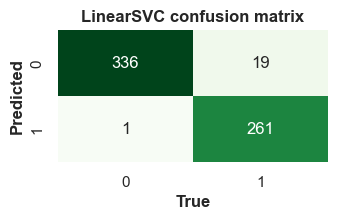

In [175]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False,fmt=".4g")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'LinearSVC_conf_matrix.pdf'), format='pdf')
plt.show()

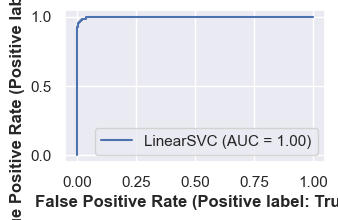

In [176]:
from sklearn.metrics import RocCurveDisplay

linear_svc_disp = RocCurveDisplay.from_estimator(lin_svc, X_test, y_test)
plt.savefig(os.path.join(IMAGE_FOLDER, 'LinearSVC_ROC.pdf'), format='pdf')

In [177]:
decision_function = lin_svc.decision_function(X_res_t)
support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
support_vectors = X_res_t[support_vector_indices]

In [178]:
support_vectors_pca = pca.transform(support_vectors)

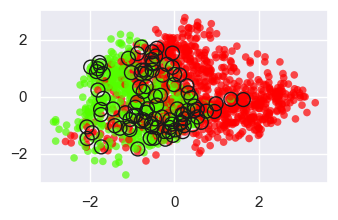

In [179]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


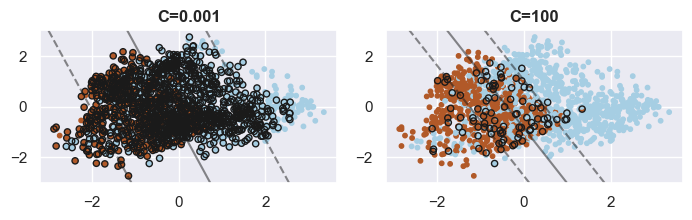

In [222]:
plt.figure(figsize=default_style.SHORT_FULLSIZE_FIGURE)

for i, C in enumerate([0.001, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="squared_hinge", penalty='l2', random_state=42).fit(X_res_t, y_res_t)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X_res_t)
#     we can also calculate the decision function manually
#     decision_function = np.dot(X_pca, clf.coef_[0]) + clf.intercept_[0]
    support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
    support_vectors = X_res_t[support_vector_indices]
    support_vectors_pca = pca.transform(support_vectors)

    plt.subplot(1, 2, i + 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, s=10, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X_pca, y_res_t)
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=20,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
    #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
plt.tight_layout()
plt.savefig(os.path.join(IMAGE_FOLDER, f'LinearSVC_C_{C}.pdf'), format='pdf')
plt.show()

The goal for SVM is find hyperplane that maximizes the margin, furthermore C is the inverse of regularization strength therefore smaller value of C correspond a stronger regularization namely greater margin

## Nonlinear SVM

In [181]:
from sklearn.svm import SVC

In [182]:
# objective function to be minimized
def objective_fun(trial):

    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.01,100)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    

    lin_svc = SVC(kernel=kernel, gamma=gamma, C=C)

    lin_svc.fit(X_res_t, y_res_t)
    y_pred = lin_svc.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-07-06 19:31:04,896] A new study created in memory with name: no-name-e31835ea-43b7-4f31-9d7f-73e25d0dae69
[I 2023-07-06 19:31:05,048] Trial 7 finished with value: 0.9834710743801653 and parameters: {'kernel': 'poly', 'C': 15.308002294246378, 'gamma': 0.6922161631338261}. Best is trial 7 with value: 0.9834710743801653.
[I 2023-07-06 19:31:05,052] Trial 5 finished with value: 0.9834710743801653 and parameters: {'kernel': 'poly', 'C': 17.676193680490925, 'gamma': 0.7540297546210493}. Best is trial 7 with value: 0.9834710743801653.
[I 2023-07-06 19:31:05,055] Trial 2 finished with value: 0.9834710743801653 and parameters: {'kernel': 'poly', 'C': 29.591439499009596, 'gamma': 0.9588644691327325}. Best is trial 7 with value: 0.9834710743801653.
[I 2023-07-06 19:31:05,381] Trial 4 finished with value: 0.9338842975206612 and parameters: {'kernel': 'rbf', 'C': 49.93772266520571, 'gamma': 0.3980970419269837}. Best is trial 7 with value: 0.9834710743801653.
[I 2023-07-06 19:31:05,518] Tria

[I 2023-07-06 19:31:06,717] Trial 38 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 67.70895408876923, 'gamma': 0.10694922522225396}. Best is trial 15 with value: 0.9917355371900827.
[I 2023-07-06 19:31:06,724] Trial 39 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 66.62313924062175, 'gamma': 0.14763898304144207}. Best is trial 15 with value: 0.9917355371900827.
[I 2023-07-06 19:31:06,797] Trial 40 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 68.470800103018, 'gamma': 0.1310277772109441}. Best is trial 15 with value: 0.9917355371900827.
[I 2023-07-06 19:31:06,884] Trial 41 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 67.79829522939318, 'gamma': 0.10718272117773014}. Best is trial 15 with value: 0.9917355371900827.
[I 2023-07-06 19:31:06,999] Trial 42 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 64.77088902140494, 'gamma':

[I 2023-07-06 19:31:08,285] Trial 75 finished with value: 0.9834710743801653 and parameters: {'kernel': 'rbf', 'C': 57.04002022719147, 'gamma': 0.2344377974687975}. Best is trial 15 with value: 0.9917355371900827.
[I 2023-07-06 19:31:08,302] Trial 74 finished with value: 0.9834710743801653 and parameters: {'kernel': 'rbf', 'C': 64.87496769585094, 'gamma': 0.23578237338212452}. Best is trial 15 with value: 0.9917355371900827.
[I 2023-07-06 19:31:08,330] Trial 78 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 66.16398863857538, 'gamma': 0.13884251877218584}. Best is trial 15 with value: 0.9917355371900827.
[I 2023-07-06 19:31:08,340] Trial 81 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 66.33920466419359, 'gamma': 0.14464926230811034}. Best is trial 15 with value: 0.9917355371900827.
[I 2023-07-06 19:31:08,349] Trial 79 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 66.02296984195142, 'gamma

[I 2023-07-06 19:31:09,646] Trial 115 finished with value: 0.9834710743801653 and parameters: {'kernel': 'poly', 'C': 63.112905271001615, 'gamma': 0.05292189285008715}. Best is trial 15 with value: 0.9917355371900827.
[I 2023-07-06 19:31:09,804] Trial 116 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 69.78927732556694, 'gamma': 0.03618992180441791}. Best is trial 15 with value: 0.9917355371900827.
[I 2023-07-06 19:31:09,824] Trial 118 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 69.8203530880866, 'gamma': 0.04197845468458622}. Best is trial 15 with value: 0.9917355371900827.
[I 2023-07-06 19:31:09,826] Trial 117 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 70.47682664492575, 'gamma': 0.0520371293078809}. Best is trial 15 with value: 0.9917355371900827.
[I 2023-07-06 19:31:09,829] Trial 121 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 65.5914503578174, '

In [183]:
best_params = study.best_params

svc = SVC(**best_params)
svc.fit(X_res_t, y_res_t)

y_pred_test = svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'kernel': 'rbf', 'C': 81.51206559491808, 'gamma': 0.09941528580236564}
              precision    recall  f1-score   support

       False       0.98      0.97      0.97       355
        True       0.96      0.97      0.96       262

    accuracy                           0.97       617
   macro avg       0.97      0.97      0.97       617
weighted avg       0.97      0.97      0.97       617

Accuracy 0.9692058346839546
F1-score [0.97304965 0.96408318]


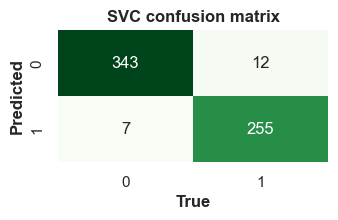

In [184]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False, fmt=".4g")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('SVC confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'SVC_conf_matrix.pdf'), format='pdf')
plt.show()

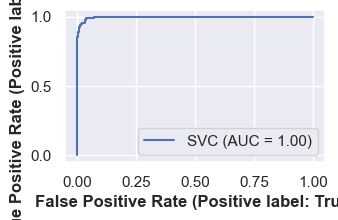

In [185]:
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)
plt.savefig(os.path.join(IMAGE_FOLDER, 'SVC_ROC.pdf'), format='pdf')

In [186]:
support_vectors_pca = pca.transform(svc.support_vectors_)

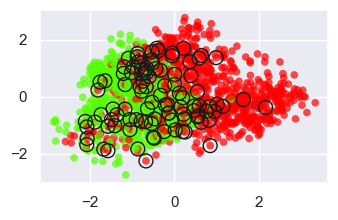

In [187]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, 
            cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [188]:
decision_function = svc.decision_function(X_res_t)
support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
support_vectors = X_res_t[support_vector_indices]

In [189]:
support_vectors_pca = pca.transform(support_vectors)

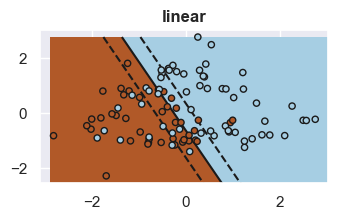

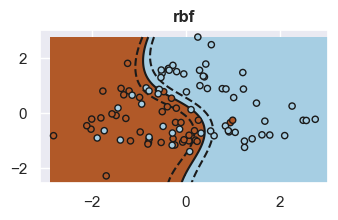

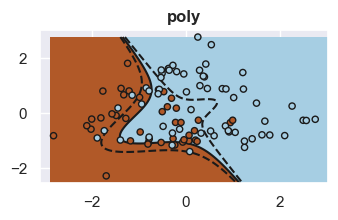

In [221]:
for kernel in ('linear', 'rbf', 'poly'):
    clf = SVC(kernel=kernel, gamma=0.1, C=26)
    clf.fit(X_res_t[:100], y_res_t[:100])

    plt.figure(figsize=default_style.SHORT_HALFSIZE_FIGURE)
    plt.clf()
    plt.scatter(X_pca[:, 0][:100], X_pca[:, 1][:100], c=y_res_t[:100], zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
#     plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=80, facecolors='none',
#                 zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X_pca[:, 0].min()
    x_max = X_pca[:, 0].max()
    y_min = X_pca[:, 1].min()
    y_max = X_pca[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    clf.fit(X_pca, y_res_t)
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
    plt.savefig(os.path.join(IMAGE_FOLDER, f'SVC_kernel_{kernel}.pdf'), format='pdf')
plt.show()

Show the different boundary for different kernel:
-Linear: just see previuos section
-Radial: Basis Function:The gamma parameters can be seen as the inverse of the radius of influence of   samples selected
-poly : the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these

# Neural Networks

In [191]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

In [192]:
from scikeras.wrappers import KerasClassifier

In [193]:
from sklearn.model_selection import RandomizedSearchCV

In [194]:
#  build the model for neural networks
def build_model(meta, hidden_layer_sizes, activation, optimizer):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(n_classes_, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [195]:
#Use Sklearn wrapper
clf = KerasClassifier(
    model = build_model,
    verbose = False
)

In [196]:
# objective function to be minimized
import random
import optuna
def objective_fun(trial):
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',[(100, 100, 100), (50, 50, 50), (10, 10, 10), 
                                  (100, 50, 10), (10, 10, 10), (10, 10)])
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    net = KerasClassifier(model=build_model(par, hidden_layer_sizes, activation, optimizer ))
    net.fit(X_res_t, y_res_t, epochs=50)
    y_pred = net.predict(X_res_v).astype(int)
#     print(y_pred.shape, y_res_v.shape)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-06 19:31:30,634] A new study created in memory with name: no-name-ed19a657-f9bc-4b21-9094-a14e023a7085
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\eman

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
46/46 [==============================] - 5s 21ms/step - loss: 0.5478 - accuracy: 0.7516
Epoch 2/50
35/46 [=====================>........] - ETA: 0s - loss: 0.4578 - accuracy: 0.8598Epoch 3/50
Epoch 3/50
46/46 [==============================] - 1s 14ms/step - loss: 0.4351 - accuracy: 0.8675
Epoch 3/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4506 - accuracy: 0.9013
Epoch 4/50
46/46 [==============================] - 0s 7ms/step - loss: 0.2257 - accuracy: 0.9469
Epoch 4/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6800 - accuracy: 0.5845
Epoch 4/50
46/46 [==============================] - 0s 7ms/step - loss: 0.3066 - accuracy: 0.9193
Epoch 4/50
46/46 [==============================] - 0s 7ms/step - loss: 0.3586 - accuracy: 0.9310
Epoch 5/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1828 - accuracy: 0.9538
Epoch 5/50
46/46 [==============

46/46 [==============================] - 0s 8ms/step - loss: 0.0915 - accuracy: 0.9703
Epoch 7/50
21/46 [============>.................] - ETA: 0s - loss: 0.0876 - accuracy: 0.9717Epoch 7/50
Epoch 12/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0971 - accuracy: 0.9689
Epoch 13/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1392 - accuracy: 0.9683
Epoch 8/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0895 - accuracy: 0.9683
Epoch 9/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0944 - accuracy: 0.9683
Epoch 14/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6781 - accuracy: 0.5845
Epoch 9/50
Epoch 14/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.9758
Epoch 10/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1152 - accuracy: 0.9683
Epoch 15/50
46/46 [==============================] - 0s 8ms/step - loss: 0.1013 - accuracy: 0.9689
Epoch 11

Epoch 18/50
Epoch 12/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6777 - accuracy: 0.5845
Epoch 17/50
42/46 [==========================>...] - ETA: 0s - loss: 0.6766 - accuracy: 0.5878Epoch 13/50
Epoch 19/50
 7/46 [===>..........................] - ETA: 0s - loss: 0.1035 - accuracy: 0.9821Epoch 13/50
Epoch 18/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0823 - accuracy: 0.9738
Epoch 19/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0779 - accuracy: 0.9765
Epoch 20/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6775 - accuracy: 0.5845
Epoch 20/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0620 - accuracy: 0.9800
Epoch 16/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0878 - accuracy: 0.9731
Epoch 23/50
14/46 [========>.....................] - ETA: 0s - loss: 0.0669 - accuracy: 0.9710Epoch 23/50
Epoch 18/50
46/46 [==============================] - 0s 10ms/step - loss: 0

15/46 [========>.....................] - ETA: 0s - loss: 0.0706 - accuracy: 0.9792Epoch 24/50
Epoch 25/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0765 - accuracy: 0.9724
Epoch 25/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0577 - accuracy: 0.9786
Epoch 21/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0905 - accuracy: 0.9724
Epoch 21/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6766 - accuracy: 0.5845
Epoch 27/50
Epoch 26/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0825 - accuracy: 0.9724
Epoch 28/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0743 - accuracy: 0.9758
Epoch 29/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0708 - accuracy: 0.9752
Epoch 24/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0784 - accuracy: 0.9738


32/46 [===================>..........] - ETA: 0s - loss: 0.0705 - accuracy: 0.9785Epoch 30/50
Epoch 31/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0677 - accuracy: 0.9786
Epoch 30/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0553 - accuracy: 0.9827
Epoch 26/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0672 - accuracy: 0.9800
Epoch 31/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0763 - accuracy: 0.9752
Epoch 32/50
Epoch 33/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0495 - accuracy: 0.9862
Epoch 28/50
Epoch 28/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0671 - accuracy: 0.9779
Epoch 28/50
Epoch 33/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0613 - accuracy: 0.9800
Epoch 28/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0479 - accuracy: 0.9883
Epoch 30/50
46/46 [==============================] - 0s 7ms/step - loss: 0.072

46/46 [==============================] - 0s 7ms/step - loss: 0.0606 - accuracy: 0.9800
Epoch 32/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0754 - accuracy: 0.9731
Epoch 38/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0596 - accuracy: 0.9827
Epoch 33/50
 1/46 [..............................] - ETA: 0s - loss: 0.1531 - accuracy: 0.9375Epoch 39/50
Epoch 32/50
17/46 [==========>...................] - ETA: 0s - loss: 0.0922 - accuracy: 0.9743Epoch 40/50
Epoch 34/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0561 - accuracy: 0.9862
Epoch 33/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0695 - accuracy: 0.9752
Epoch 35/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0460 - accuracy: 0.9876
Epoch 36/50
 6/46 [==>...........................] - ETA: 0s - loss: 0.0351 - accuracy: 0.9844Epoch 36/50
Epoch 35/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0467 - accuracy: 0.9834

46/46 [==============================] - 1s 11ms/step - loss: 0.0406 - accuracy: 0.9841
Epoch 44/50
12/46 [======>.......................] - ETA: 0s - loss: 0.0670 - accuracy: 0.9818Epoch 46/50
Epoch 40/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0539 - accuracy: 0.9834
Epoch 40/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0623 - accuracy: 0.9834
Epoch 41/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0421 - accuracy: 0.9855
Epoch 42/50
10/46 [=====>........................] - ETA: 0s - loss: 0.0437 - accuracy: 0.9906Epoch 46/50
Epoch 48/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0607 - accuracy: 0.9772
Epoch 47/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0514 - accuracy: 0.9848
Epoch 41/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6735 - accuracy: 0.5845
Epoch 46/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0498 - accuracy: 0.9848
Epoch 4

46/46 [==============================] - 1s 12ms/step - loss: 0.0403 - accuracy: 0.9862
Epoch 46/50
 1/46 [..............................] - ETA: 0s - loss: 0.0530 - accuracy: 0.9688Epoch 49/50
Epoch 44/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0463 - accuracy: 0.9855
Epoch 46/50
25/46 [===============>..............] - ETA: 0s - loss: 0.0565 - accuracy: 0.9825

[I 2023-07-06 19:31:56,350] Trial 3 finished with value: 0.9669421487603306 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9669421487603306.


36/46 [======================>.......] - ETA: 0s - loss: 0.6683 - accuracy: 0.5972

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 12ms/step - loss: 0.0499 - accuracy: 0.9841
Epoch 50/50
12/12 [==============================] - 0s 12ms/stepss: 0.0486 - accuracy: 0.98
Epoch 1/50
39/46 [========================>.....] - ETA: 0s - loss: 0.6704 - accuracy: 0.5913

[I 2023-07-06 19:31:57,199] Trial 0 finished with value: 0.9559228650137741 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9669421487603306.


46/46 [==============================] - 1s 11ms/step - loss: 0.0405 - accuracy: 0.9876
Epoch 48/50
45/46 [============================>.] - ETA: 0s - loss: 0.0462 - accuracy: 0.9868

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 16ms/step - loss: 0.0459 - accuracy: 0.9869
Epoch 46/50
43/46 [===========================>..] - ETA: 0s - loss: 0.0604 - accuracy: 0.9826

[I 2023-07-06 19:31:57,749] Trial 6 finished with value: 0.9752066115702479 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9752066115702479.


 7/12 [================>.............] - ETA: 0s - loss: 0.0494 - accuracy: 0.98Epoch 48/50
Epoch 49/50
11/12 [==========================>...] - ETA: 0s - loss: 0.0479 - accuracy: 0.98

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 14ms/step - loss: 0.0472 - accuracy: 0.9862


[I 2023-07-06 19:31:58,093] Trial 1 finished with value: 0.6170798898071626 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9752066115702479.


14/46 [========>.....................] - ETA: 0s - loss: 0.0407 - accuracy: 0.9888

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 13ms/step - loss: 0.0392 - accuracy: 0.9855
Epoch 50/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0500 - accuracy: 0.9841
Epoch 49/50
42/46 [==========================>...] - ETA: 0s - loss: 0.0539 - accuracy: 0.9859

[I 2023-07-06 19:32:00,130] Trial 4 finished with value: 0.9724517906336089 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9752066115702479.
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for 

46/46 [==============================] - 0s 10ms/step - loss: 0.0508 - accuracy: 0.9869
Epoch 50/50
 5/46 [==>...........................] - ETA: 0s - loss: 0.0234 - accuracy: 0.9937

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

28/46 [=================>............] - ETA: 0s - loss: 0.0326 - accuracy: 0.9922

[I 2023-07-06 19:32:00,724] Trial 7 finished with value: 0.9724517906336089 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9752066115702479.


32/46 [===================>..........] - ETA: 0s - loss: 0.0384 - accuracy: 0.9893Epoch 1/50
Epoch 1/50
43/46 [===========================>..] - ETA: 0s - loss: 0.0448 - accuracy: 0.9876

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 4s 15ms/step - loss: 0.6993 - accuracy: 0.4776
Epoch 2/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6735 - accuracy: 0.6908


[I 2023-07-06 19:32:01,852] Trial 5 finished with value: 0.9724517906336089 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9752066115702479.


Epoch 3/50
 1/46 [..............................] - ETA: 2:46 - loss: 0.7707 - accuracy: 0.3750

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 12ms/step - loss: 0.6838 - accuracy: 0.5845
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6266 - accuracy: 0.8309
Epoch 6/50
46/46 [==============================] - 1s 21ms/step - loss: 0.6780 - accuracy: 0.5845
Epoch 5/50
46/46 [==============================] - 7s 21ms/step - loss: 0.5774 - accuracy: 0.7474
Epoch 2/50
Epoch 2/50
46/46 [==============================] - 7s 22ms/step - loss: 0.3001 - accuracy: 0.8682
Epoch 3/50
46/46 [==============================] - 1s 16ms/step - loss: 0.4520 - accuracy: 0.8634
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1560 - accuracy: 0.9538
Epoch 2/50
Epoch 4/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6723 - accuracy: 0.5845
Epoch 5/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6774 - accuracy: 0.5845
Epoch 8/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6714 - accuracy: 0.5845
Epoc

46/46 [==============================] - 0s 8ms/step - loss: 0.2221 - accuracy: 0.9469
Epoch 12/50
46/46 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.9634Epoch 13/50
Epoch 9/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6671 - accuracy: 0.5845
Epoch 10/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6772 - accuracy: 0.5845
Epoch 14/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6662 - accuracy: 0.5845
Epoch 11/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6652 - accuracy: 0.5845
Epoch 12/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6770 - accuracy: 0.5845
Epoch 16/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0643 - accuracy: 0.9786
Epoch 12/50
Epoch 8/50
13/46 [=======>......................] - ETA: 0s - loss: 0.0956 - accuracy: 0.9591Epoch 13/50
Epoch 14/50
37/46 [=======================>......] - ETA: 0s - loss: 0.6632 - accuracy: 0.5853Epo

46/46 [==============================] - 1s 12ms/step - loss: 0.0818 - accuracy: 0.9752
Epoch 10/50
Epoch 15/50
 1/46 [..............................] - ETA: 0s - loss: 0.0456 - accuracy: 1.0000Epoch 16/50
Epoch 15/50
46/46 [==============================] - 1s 14ms/step - loss: 0.2005 - accuracy: 0.9593
Epoch 21/50
44/46 [===========================>..] - ETA: 0s - loss: 0.6778 - accuracy: 0.5895Epoch 16/50
Epoch 11/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0910 - accuracy: 0.9669
Epoch 13/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1904 - accuracy: 0.9620
Epoch 20/50
Epoch 22/50
28/46 [=================>............] - ETA: 0s - loss: 0.1758 - accuracy: 0.9676Epoch 17/50
Epoch 16/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6594 - accuracy: 0.5845
Epoch 14/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0659 - accuracy: 0.9765
Epoch 13/50
Epoch 18/50
34/46 [=====================>........] - ETA: 

46/46 [==============================] - 1s 12ms/step - loss: 0.1525 - accuracy: 0.9669
Epoch 18/50
Epoch 27/50
28/46 [=================>............] - ETA: 0s - loss: 0.6738 - accuracy: 0.5926Epoch 23/50
Epoch 22/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0527 - accuracy: 0.9786
Epoch 28/50
Epoch 21/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6790 - accuracy: 0.5845
Epoch 26/50
Epoch 19/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0790 - accuracy: 0.9710
Epoch 24/50
Epoch 18/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6764 - accuracy: 0.5845
Epoch 22/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0582 - accuracy: 0.9807
Epoch 24/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6786 - accuracy: 0.5845
Epoch 21/50
40/46 [=========================>....] - ETA: 0s - loss: 0.0824 - accuracy: 0.9688Epoch 20/50
Epoch 25/50
46/46 [==============================] - 

15/46 [========>.....................] - ETA: 0s - loss: 0.0790 - accuracy: 0.9667Epoch 25/50
Epoch 24/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1232 - accuracy: 0.9731
Epoch 35/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0800 - accuracy: 0.9731
Epoch 29/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6775 - accuracy: 0.5845
Epoch 26/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6323 - accuracy: 0.5845
Epoch 29/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1162 - accuracy: 0.9752
Epoch 37/50
19/46 [===========>..................] - ETA: 0s - loss: 0.0645 - accuracy: 0.9720Epoch 33/50
Epoch 30/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0541 - accuracy: 0.9834
Epoch 28/50
46/46 [==============================] - 0s 8ms/step - loss: 0.1124 - accuracy: 0.9717
Epoch 33/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0693 - accuracy: 0.9786
Epoch

46/46 [==============================] - 1s 12ms/step - loss: 0.0448 - accuracy: 0.9890
Epoch 30/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0546 - accuracy: 0.9807
Epoch 33/50
Epoch 35/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1088 - accuracy: 0.9731
Epoch 41/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6755 - accuracy: 0.5845
Epoch 39/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1069 - accuracy: 0.9738
Epoch 36/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6126 - accuracy: 0.5914
Epoch 38/50
10/46 [=====>........................] - ETA: 0s - loss: 0.6037 - accuracy: 0.6031Epoch 37/50
Epoch 43/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0442 - accuracy: 0.9855
Epoch 37/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0517 - accuracy: 0.9814
Epoch 44/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6753 - accuracy: 0.5852

46/46 [==============================] - 0s 9ms/step - loss: 0.0642 - accuracy: 0.9786
Epoch 37/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5907 - accuracy: 0.6494
Epoch 42/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6756 - accuracy: 0.5845
Epoch 40/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0633 - accuracy: 0.9800
Epoch 46/50
32/46 [===================>..........] - ETA: 0s - loss: 0.6763 - accuracy: 0.5820Epoch 44/50
Epoch 43/50
19/46 [===========>..................] - ETA: 0s - loss: 0.5778 - accuracy: 0.6579Epoch 41/50
Epoch 39/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0631 - accuracy: 0.9807
Epoch 39/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6748 - accuracy: 0.5845
Epoch 43/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0385 - accuracy: 0.9896
Epoch 44/50
Epoch 45/50
32/46 [===================>..........] - ETA: 0s - loss: 0.0678 - accuracy: 0.

[I 2023-07-06 19:32:24,937] Trial 8 finished with value: 0.9614325068870524 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9752066115702479.


46/46 [==============================] - 0s 6ms/step - loss: 0.6745 - accuracy: 0.5845
Epoch 42/50
Epoch 50/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0605 - accuracy: 0.9793
Epoch 42/50
17/46 [==========>...................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9982

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

22/46 [=============>................] - ETA: 0s - loss: 0.0084 - accuracy: 0.9986Epoch 48/50
Epoch 47/50
45/46 [============================>.] - ETA: 0s - loss: 0.0459 - accuracy: 0.9847Epoch 1/50
Epoch 43/50
41/46 [=========================>....] - ETA: 0s - loss: 0.0394 - accuracy: 0.9855Epoch 47/50
Epoch 43/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0386 - accuracy: 0.9855
Epoch 48/50
46/46 [==============================] - 1s 14ms/step - loss: 0.6751 - accuracy: 0.5845
Epoch 46/50
 9/46 [====>.........................] - ETA: 0s - loss: 0.6865 - accuracy: 0.5521Epoch 48/50


[I 2023-07-06 19:32:26,391] Trial 10 finished with value: 0.6170798898071626 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9752066115702479.


25/46 [===============>..............] - ETA: 0s - loss: 0.6712 - accuracy: 0.5913

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 15ms/step - loss: 0.0379 - accuracy: 0.9848
Epoch 47/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5427 - accuracy: 0.8199
Epoch 49/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0441 - accuracy: 0.9862
Epoch 45/50
10/46 [=====>........................] - ETA: 0s - loss: 0.0173 - accuracy: 0.9906

[I 2023-07-06 19:32:27,637] Trial 13 finished with value: 0.8484848484848485 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9752066115702479.


21/46 [============>.................] - ETA: 0s - loss: 0.0653 - accuracy: 0.9777

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

 7/46 [===>..........................] - ETA: 0s - loss: 0.6570 - accuracy: 0.6250  

[I 2023-07-06 19:32:28,313] Trial 9 finished with value: 0.9724517906336089 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 6 with value: 0.9752066115702479.


46/46 [==============================] - 1s 16ms/step - loss: 0.0441 - accuracy: 0.9834
Epoch 47/50
31/46 [===================>..........] - ETA: 0s - loss: 0.0148 - accuracy: 0.9940

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 11ms/step - loss: 0.0154 - accuracy: 0.9938
Epoch 50/50
12/12 [==============================] - 0s 13ms/stepss: 0.0462 - accuracy: 0.96
Epoch 48/50
10/46 [=====>........................] - ETA: 0s - loss: 0.0127 - accuracy: 0.9906

[I 2023-07-06 19:32:28,888] Trial 12 finished with value: 0.9641873278236914 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 6 with value: 0.9752066115702479.


17/46 [==========>...................] - ETA: 0s - loss: 0.6812 - accuracy: 0.5643

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 20ms/step - loss: 0.6741 - accuracy: 0.5845
Epoch 49/50
46/46 [==============================] - 4s 19ms/step - loss: 0.6861 - accuracy: 0.5845
Epoch 2/50
12/12 [==============================] - 0s 7ms/step
Epoch 50/50
39/46 [========================>.....] - ETA: 0s - loss: 0.5688 - accuracy: 0.6747

[I 2023-07-06 19:32:30,646] Trial 11 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 1s 16ms/step - loss: 0.0356 - accuracy: 0.9910
Epoch 50/50
 1/46 [..............................] - ETA: 0s - loss: 0.4754 - accuracy: 0.7500

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 13ms/step - loss: 0.3976 - accuracy: 0.8854
Epoch 2/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0389 - accuracy: 0.9876
Epoch 4/50
46/46 [==============================] - 1s 12ms/step - loss: 0.2813 - accuracy: 0.9289
Epoch 5/50
12/12 [==============================] - 0s 6ms/steposs: 0.2926 - accuracy: 0.90


[I 2023-07-06 19:32:31,980] Trial 15 finished with value: 0.6170798898071626 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 11 with value: 0.9862258953168044.


 8/46 [====>.........................] - ETA: 0s - loss: 0.2352 - accuracy: 0.9492

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

14/46 [========>.....................] - ETA: 0s - loss: 0.2236 - accuracy: 0.9531

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 24ms/step - loss: 0.2150 - accuracy: 0.9476
Epoch 1/50
Epoch 6/50
46/46 [==============================] - 1s 21ms/step - loss: 0.4258 - accuracy: 0.8827
Epoch 5/50
46/46 [==============================] - 1s 18ms/step - loss: 0.1595 - accuracy: 0.9565
Epoch 8/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2664 - accuracy: 0.9365
Epoch 7/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1878 - accuracy: 0.9524
Epoch 9/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1255 - accuracy: 0.9600
Epoch 11/50
46/46 [==============================] - 1s 12ms/step - loss: 0.2187 - accuracy: 0.9503
Epoch 3/50
46/46 [==============================] - 7s 8ms/step - loss: 0.3240 - accuracy: 0.8440
Epoch 2/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0939 - accuracy: 0.9689
Epoch 13/50
Epoch 6/50
46/46 [==============================] - 1s 18ms/step - loss: 0.1051 - accuracy: 0.9655

27/46 [================>.............] - ETA: 0s - loss: 0.1122 - accuracy: 0.9572Epoch 9/50
Epoch 18/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1044 - accuracy: 0.9669
Epoch 19/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0613 - accuracy: 0.9821
Epoch 9/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0957 - accuracy: 0.9614
Epoch 5/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0913 - accuracy: 0.9696
Epoch 18/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0899 - accuracy: 0.9696
Epoch 4/50
37/46 [=======================>......] - ETA: 0s - loss: 0.0572 - accuracy: 0.9789Epoch 21/50
Epoch 19/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0843 - accuracy: 0.9689
Epoch 20/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0658 - accuracy: 0.9772
Epoch 12/50
38/46 [=======================>......] - ETA: 0s - loss: 0.0768 - accuracy: 0.9762Epoch 21/50


44/46 [===========================>..] - ETA: 0s - loss: 0.0543 - accuracy: 0.9822Epoch 25/50
Epoch 23/50
35/46 [=====================>........] - ETA: 0s - loss: 0.0435 - accuracy: 0.9866Epoch 26/50
Epoch 24/50
Epoch 9/50
45/46 [============================>.] - ETA: 0s - loss: 0.1085 - accuracy: 0.9556Epoch 27/50
Epoch 25/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1078 - accuracy: 0.9558
Epoch 10/50
Epoch 18/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0859 - accuracy: 0.9724
Epoch 28/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0639 - accuracy: 0.9765
Epoch 27/50
 1/46 [..............................] - ETA: 1s - loss: 0.0759 - accuracy: 0.9688Epoch 20/50
Epoch 29/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0923 - accuracy: 0.9593
Epoch 14/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0487 - accuracy: 0.9834
Epoch 21/50
46/46 [==============================] - 0s 9ms/step - l

46/46 [==============================] - 0s 9ms/step - loss: 0.0407 - accuracy: 0.9848
Epoch 23/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0866 - accuracy: 0.9648
Epoch 20/50
Epoch 24/50
13/46 [=======>......................] - ETA: 0s - loss: 0.0403 - accuracy: 0.9880Epoch 19/50
Epoch 33/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0394 - accuracy: 0.9869
Epoch 27/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0511 - accuracy: 0.9841
Epoch 23/50
23/46 [==============>...............] - ETA: 0s - loss: 0.0256 - accuracy: 0.9946Epoch 28/50
Epoch 37/50
19/46 [===========>..................] - ETA: 0s - loss: 0.1104 - accuracy: 0.9556Epoch 27/50
Epoch 29/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0485 - accuracy: 0.9876
Epoch 20/50


46/46 [==============================] - 0s 8ms/step - loss: 0.0699 - accuracy: 0.9765
Epoch 38/50
17/46 [==========>...................] - ETA: 0s - loss: 0.0220 - accuracy: 0.9926Epoch 29/50
Epoch 22/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0746 - accuracy: 0.9717
Epoch 25/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0683 - accuracy: 0.9800
Epoch 21/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0684 - accuracy: 0.9779
Epoch 37/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0726 - accuracy: 0.9758
Epoch 38/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0358 - accuracy: 0.9896
Epoch 40/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0442 - accuracy: 0.9841
Epoch 24/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0446 - accuracy: 0.9827
Epoch 41/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0347 - accuracy: 0.9869
Epoch 33/5

46/46 [==============================] - 1s 11ms/step - loss: 0.0226 - accuracy: 0.9924
Epoch 36/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0508 - accuracy: 0.9834
Epoch 36/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0667 - accuracy: 0.9793
Epoch 44/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0673 - accuracy: 0.9786
Epoch 46/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0277 - accuracy: 0.9890
Epoch 28/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0661 - accuracy: 0.9793
Epoch 33/50
 6/46 [==>...........................] - ETA: 0s - loss: 0.0765 - accuracy: 0.9740Epoch 38/50
Epoch 29/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0642 - accuracy: 0.9779
Epoch 31/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0232 - accuracy: 0.9931
Epoch 46/50
Epoch 34/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0650 - accuracy: 0.98

Epoch 42/50
Epoch 33/50
12/12 [==============================] - 0s 9ms/steposs: 0.0657 - accuracy: 0.98
Epoch 34/50
11/46 [======>.......................] - ETA: 0s - loss: 0.0719 - accuracy: 0.9659

[I 2023-07-06 19:32:56,049] Trial 16 finished with value: 0.9641873278236914 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 11 with value: 0.9862258953168044.


22/46 [=============>................] - ETA: 0s - loss: 0.0282 - accuracy: 0.9957

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 13ms/step - loss: 0.0248 - accuracy: 0.9917
Epoch 39/50
17/46 [==========>...................] - ETA: 0s - loss: 0.0969 - accuracy: 0.9651Epoch 42/50
Epoch 35/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0599 - accuracy: 0.9738
Epoch 44/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0277 - accuracy: 0.9896
Epoch 37/50
28/46 [=================>............] - ETA: 0s - loss: 0.0242 - accuracy: 0.9888

[I 2023-07-06 19:32:56,992] Trial 17 finished with value: 0.9476584022038568 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 11 with value: 0.9862258953168044.


35/46 [=====================>........] - ETA: 0s - loss: 0.0175 - accuracy: 0.9946

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 17ms/step - loss: 0.0249 - accuracy: 0.9903
Epoch 45/50
Epoch 36/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0295 - accuracy: 0.9890
Epoch 48/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0090 - accuracy: 0.9979
Epoch 46/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0325 - accuracy: 0.9917
Epoch 49/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0185 - accuracy: 0.9945
Epoch 49/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0310 - accuracy: 0.9910
Epoch 42/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0394 - accuracy: 0.9869
Epoch 47/50
11/46 [======>.......................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9943

[I 2023-07-06 19:33:02,115] Trial 19 finished with value: 0.977961432506887 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


43/46 [===========================>..] - ETA: 0s - loss: 0.0165 - accuracy: 0.9949

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 12ms/step - loss: 0.0165 - accuracy: 0.9945


C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

Epoch 50/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0207 - accuracy: 0.9917
Epoch 43/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0178 - accuracy: 0.9952
Epoch 45/50
Epoch 48/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0235 - accuracy: 0.9896
Epoch 46/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0965 - accuracy: 0.9655
Epoch 45/50
42/46 [==========================>...] - ETA: 0s - loss: 0.0268 - accuracy: 0.9903

[I 2023-07-06 19:33:03,863] Trial 20 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 1s 12ms/step - loss: 0.0273 - accuracy: 0.9903
Epoch 47/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0319 - accuracy: 0.9876
Epoch 50/50


C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 18ms/step - loss: 0.0452 - accuracy: 0.9855
Epoch 46/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0154 - accuracy: 0.9959
Epoch 48/50
46/46 [==============================] - 7s 15ms/step - loss: 0.5201 - accuracy: 0.7957
Epoch 2/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1558 - accuracy: 0.9510
Epoch 47/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0158 - accuracy: 0.9938
Epoch 49/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2247 - accuracy: 0.9434
Epoch 3/50
12/46 [======>.......................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9974

[I 2023-07-06 19:33:05,448] Trial 21 finished with value: 0.9807162534435262 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


39/46 [========================>.....] - ETA: 0s - loss: 0.0149 - accuracy: 0.9960  

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 0s 10ms/step - loss: 0.1294 - accuracy: 0.9600
Epoch 4/50
46/46 [==============================] - 1s 19ms/step - loss: 0.1021 - accuracy: 0.9662
Epoch 6/50
43/46 [===========================>..] - ETA: 0s - loss: 0.0824 - accuracy: 0.9731

[I 2023-07-06 19:33:07,751] Trial 23 finished with value: 0.977961432506887 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


11/46 [======>.......................] - ETA: 0s - loss: 0.0556 - accuracy: 0.9801

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

20/46 [============>.................] - ETA: 0s - loss: 0.0514 - accuracy: 0.9844

[I 2023-07-06 19:33:08,486] Trial 22 finished with value: 0.9752066115702479 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 0s 8ms/step - loss: 0.0816 - accuracy: 0.9738
Epoch 8/50
40/46 [=========================>....] - ETA: 0s - loss: 0.0611 - accuracy: 0.9805

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 0s 11ms/step - loss: 0.0776 - accuracy: 0.9745
Epoch 11/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1181 - accuracy: 0.9593
Epoch 4/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1298 - accuracy: 0.9489
Epoch 5/50
46/46 [==============================] - 7s 10ms/step - loss: 0.2503 - accuracy: 0.9041
Epoch 14/50
Epoch 2/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0859 - accuracy: 0.9731
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0723 - accuracy: 0.9779
Epoch 13/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0639 - accuracy: 0.9807
Epoch 15/50
37/46 [=======================>......] - ETA: 0s - loss: 0.0679 - accuracy: 0.9755Epoch 15/50
Epoch 2/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0784 - accuracy: 0.9689
Epoch 6/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0993 - accuracy: 0.9627
Epoc

46/46 [==============================] - 0s 8ms/step - loss: 0.1035 - accuracy: 0.9600
Epoch 8/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0499 - accuracy: 0.9869
Epoch 21/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0878 - accuracy: 0.9710
Epoch 3/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0537 - accuracy: 0.9841
Epoch 20/50
Epoch 22/50
13/46 [=======>......................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9663Epoch 23/50
Epoch 8/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0682 - accuracy: 0.9765
Epoch 11/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0550 - accuracy: 0.9807
Epoch 14/50
33/46 [====================>.........] - ETA: 0s - loss: 0.1115 - accuracy: 0.9470Epoch 9/50
Epoch 22/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0620 - accuracy: 0.9793
Epoch 15/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0502 - accuracy: 0.9

46/46 [==============================] - 0s 10ms/step - loss: 0.0469 - accuracy: 0.9834
Epoch 18/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0754 - accuracy: 0.9710
Epoch 10/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0536 - accuracy: 0.9827
Epoch 16/50
44/46 [===========================>..] - ETA: 0s - loss: 0.0501 - accuracy: 0.9815Epoch 14/50
Epoch 19/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0515 - accuracy: 0.9821
Epoch 15/50
Epoch 20/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0762 - accuracy: 0.9738
Epoch 11/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0773 - accuracy: 0.9724
Epoch 19/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0545 - accuracy: 0.9827
Epoch 14/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0961 - accuracy: 0.9634
Epoch 23/50
 1/46 [..............................] - ETA: 0s - loss: 0.0623 - accuracy: 0.9688E

46/46 [==============================] - 0s 10ms/step - loss: 0.0360 - accuracy: 0.9910
Epoch 32/50
36/46 [======================>.......] - ETA: 0s - loss: 0.0459 - accuracy: 0.9844Epoch 24/50
Epoch 25/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0400 - accuracy: 0.9876
Epoch 18/50
Epoch 26/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0607 - accuracy: 0.9793
Epoch 27/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0501 - accuracy: 0.9827
Epoch 22/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0471 - accuracy: 0.9848
Epoch 19/50
Epoch 27/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0366 - accuracy: 0.9896
Epoch 38/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0362 - accuracy: 0.9910
Epoch 29/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0436 - accuracy: 0.9827
Epoch 20/50
23/46 [==============>...............] - ETA: 0s - loss: 0.0247 - accurac

46/46 [==============================] - 1s 12ms/step - loss: 0.0326 - accuracy: 0.9890
Epoch 30/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0598 - accuracy: 0.9752
Epoch 23/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0525 - accuracy: 0.9862
Epoch 32/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0630 - accuracy: 0.9745
Epoch 33/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0388 - accuracy: 0.9890
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0356 - accuracy: 0.9862
Epoch 42/50
Epoch 25/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0337 - accuracy: 0.9910
Epoch 45/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0260 - accuracy: 0.9917
Epoch 26/50
13/46 [=======>......................] - ETA: 0s - loss: 0.0578 - accuracy: 0.9904Epoch 35/50
Epoch 43/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0320 - accuracy: 0.99

46/46 [==============================] - 0s 11ms/step - loss: 0.0323 - accuracy: 0.9876
Epoch 36/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0302 - accuracy: 0.9924
Epoch 28/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0801 - accuracy: 0.9696
Epoch 33/50
28/46 [=================>............] - ETA: 0s - loss: 0.0260 - accuracy: 0.9900Epoch 34/50
Epoch 50/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0217 - accuracy: 0.9917
Epoch 39/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0275 - accuracy: 0.9931
Epoch 48/50
Epoch 40/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0257 - accuracy: 0.9924
Epoch 35/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0297 - accuracy: 0.9869
Epoch 38/50
Epoch 41/50
Epoch 50/50
12/46 [======>.......................] - ETA: 0s - loss: 0.0072 - accuracy: 0.9948

[I 2023-07-06 19:33:30,304] Trial 24 finished with value: 0.9696969696969697 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


35/46 [=====================>........] - ETA: 0s - loss: 0.0129 - accuracy: 0.9955

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 13ms/step - loss: 0.0375 - accuracy: 0.9807
Epoch 40/50
12/12 [==============================] - 0s 10ms/stepss: 0.0293 - accuracy: 0.98
Epoch 38/50
45/46 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9903Epoch 44/50


[I 2023-07-06 19:33:31,580] Trial 25 finished with value: 0.9724517906336089 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 1s 15ms/step - loss: 0.0262 - accuracy: 0.9903
Epoch 35/50
12/46 [======>.......................] - ETA: 0s - loss: 0.0070 - accuracy: 1.0000

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 15ms/step - loss: 0.0107 - accuracy: 0.9979
Epoch 39/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0365 - accuracy: 0.9910
Epoch 36/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0214 - accuracy: 0.9965
Epoch 43/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0238 - accuracy: 0.9890
Epoch 46/50
Epoch 47/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0251 - accuracy: 0.9903
Epoch 38/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0234 - accuracy: 0.9931
Epoch 39/50
Epoch 48/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0201 - accuracy: 0.9931
Epoch 48/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0190 - accuracy: 0.9952
Epoch 49/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0189 - accuracy: 0.9959
Epoch 45/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0197 - accur

[I 2023-07-06 19:33:37,000] Trial 26 finished with value: 0.9807162534435262 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


 8/46 [====>.........................] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

25/46 [===============>..............] - ETA: 0s - loss: 0.5875 - accuracy: 0.7225

[I 2023-07-06 19:33:37,722] Trial 27 finished with value: 0.977961432506887 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 1s 17ms/step - loss: 0.0139 - accuracy: 0.9965
Epoch 44/50
42/46 [==========================>...] - ETA: 0s - loss: 0.5116 - accuracy: 0.8103

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

43/46 [===========================>..] - ETA: 0s - loss: 0.0550 - accuracy: 0.9804Epoch 1/50
Epoch 45/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0346 - accuracy: 0.9883
Epoch 46/50
46/46 [==============================] - 1s 17ms/step - loss: 0.1316 - accuracy: 0.9641
Epoch 4/50
12/12 [==============================] - 0s 9ms/step
Epoch 47/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0232 - accuracy: 0.9890
Epoch 5/50
Epoch 47/50
 1/46 [..............................] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

[I 2023-07-06 19:33:40,095] Trial 28 finished with value: 0.977961432506887 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 1s 15ms/step - loss: 0.1040 - accuracy: 0.9607


C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 12ms/step - loss: 0.0940 - accuracy: 0.9669
Epoch 48/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0102 - accuracy: 0.9979
Epoch 48/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0934 - accuracy: 0.9683
Epoch 4/50
41/46 [=========================>....] - ETA: 0s - loss: 0.0847 - accuracy: 0.9718

[I 2023-07-06 19:33:40,964] Trial 29 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


42/46 [==========================>...] - ETA: 0s - loss: 0.0082 - accuracy: 0.9978Epoch 7/50


C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 12ms/step - loss: 0.0100 - accuracy: 0.9965
Epoch 49/50
46/46 [==============================] - 1s 24ms/step - loss: 0.0847 - accuracy: 0.9676
Epoch 9/50
46/46 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9731

[I 2023-07-06 19:33:43,546] Trial 31 finished with value: 0.9752066115702479 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 1s 12ms/step - loss: 0.0761 - accuracy: 0.9731
Epoch 10/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0703 - accuracy: 0.9758


C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

Epoch 8/50
 1/46 [..............................] - ETA: 0s - loss: 0.0539 - accuracy: 1.0000

[I 2023-07-06 19:33:43,801] Trial 30 finished with value: 0.9641873278236914 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


10/46 [=====>........................] - ETA: 0s - loss: 0.0491 - accuracy: 0.9844Epoch 1/50


C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 0s 10ms/step - loss: 0.0834 - accuracy: 0.9655
Epoch 9/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0661 - accuracy: 0.9800
Epoch 12/50
46/46 [==============================] - 7s 18ms/step - loss: 0.4677 - accuracy: 0.8344
Epoch 2/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0593 - accuracy: 0.9827
Epoch 10/50
46/46 [==============================] - 7s 22ms/step - loss: 0.5063 - accuracy: 0.7964
Epoch 3/50
Epoch 2/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0688 - accuracy: 0.9786
Epoch 11/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1016 - accuracy: 0.9669
Epoch 14/50
17/46 [==========>...................] - ETA: 0s - loss: 0.1849 - accuracy: 0.9467Epoch 15/50
Epoch 12/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1463 - accuracy: 0.9558
Epoch 5/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0640 - accuracy: 0.9758
E

46/46 [==============================] - 6s 12ms/step - loss: 0.5821 - accuracy: 0.6867
Epoch 8/50
Epoch 2/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0682 - accuracy: 0.9779
Epoch 14/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1324 - accuracy: 0.9600
Epoch 4/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0528 - accuracy: 0.9786
Epoch 5/50
29/46 [=================>............] - ETA: 0s - loss: 0.1043 - accuracy: 0.9623Epoch 16/50
Epoch 11/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0620 - accuracy: 0.9807
Epoch 16/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0733 - accuracy: 0.9765
Epoch 12/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0583 - accuracy: 0.9814
Epoch 11/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0404 - accuracy: 0.9903
Epoch 24/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0825 - accuracy: 0.973

46/46 [==============================] - 0s 9ms/step - loss: 0.0584 - accuracy: 0.9841
Epoch 19/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0801 - accuracy: 0.9710
Epoch 26/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0659 - accuracy: 0.9779
Epoch 15/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0521 - accuracy: 0.9827
Epoch 10/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0635 - accuracy: 0.9786
Epoch 16/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0659 - accuracy: 0.9758
Epoch 32/50
12/46 [======>.......................] - ETA: 0s - loss: 0.0456 - accuracy: 0.9792Epoch 15/50
Epoch 28/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0616 - accuracy: 0.9772
Epoch 22/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0628 - accuracy: 0.9779
Epoch 23/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0546 - accuracy: 0.9786
Epoch 1

46/46 [==============================] - 0s 10ms/step - loss: 0.0592 - accuracy: 0.9800
Epoch 15/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0812 - accuracy: 0.9703
Epoch 15/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0642 - accuracy: 0.9758
Epoch 37/50
Epoch 26/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0331 - accuracy: 0.9869
Epoch 33/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0583 - accuracy: 0.9807
Epoch 34/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0517 - accuracy: 0.9855
Epoch 27/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0473 - accuracy: 0.9862
Epoch 28/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0616 - accuracy: 0.9793
Epoch 23/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0530 - accuracy: 0.9834
Epoch 24/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0452 - accuracy: 0.9855
E

46/46 [==============================] - 0s 8ms/step - loss: 0.0226 - accuracy: 0.9931
Epoch 40/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0438 - accuracy: 0.9876
Epoch 24/50
14/46 [========>.....................] - ETA: 0s - loss: 0.0297 - accuracy: 0.9888Epoch 29/50
Epoch 24/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0439 - accuracy: 0.9883
Epoch 34/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0209 - accuracy: 0.9924
Epoch 41/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0470 - accuracy: 0.9848
Epoch 46/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 0.9903
Epoch 42/50
46/46 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9869Epoch 31/50
Epoch 47/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0435 - accuracy: 0.9848
Epoch 36/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0423 - accuracy: 0.9890
Epoch 36

46/46 [==============================] - 0s 9ms/step - loss: 0.0384 - accuracy: 0.9896
Epoch 38/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0456 - accuracy: 0.9876
Epoch 29/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0158 - accuracy: 0.9952
Epoch 46/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0673 - accuracy: 0.9752
Epoch 30/50
14/46 [========>.....................] - ETA: 0s - loss: 0.0310 - accuracy: 0.9866Epoch 30/50
Epoch 35/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0646 - accuracy: 0.9772
Epoch 41/50
 1/46 [..............................] - ETA: 0s - loss: 0.0591 - accuracy: 0.9688

[I 2023-07-06 19:34:05,088] Trial 32 finished with value: 0.9696969696969697 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


33/46 [====================>.........] - ETA: 0s - loss: 0.0653 - accuracy: 0.9811

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 12ms/step - loss: 0.0569 - accuracy: 0.9821
Epoch 32/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0469 - accuracy: 0.9848
Epoch 39/50
Epoch 34/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0488 - accuracy: 0.9841
Epoch 40/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0549 - accuracy: 0.9821
Epoch 35/50
Epoch 40/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0376 - accuracy: 0.9862
Epoch 45/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0485 - accuracy: 0.9834
Epoch 46/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0488 - accuracy: 0.9876
Epoch 36/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0385 - accuracy: 0.9876
Epoch 36/50
Epoch 41/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0409 - accuracy: 0.9841


[I 2023-07-06 19:34:08,050] Trial 33 finished with value: 0.9807162534435262 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


26/46 [===============>..............] - ETA: 0s - loss: 0.0405 - accuracy: 0.9844

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 0s 8ms/step - loss: 0.0467 - accuracy: 0.9841
Epoch 42/50
 1/46 [..............................] - ETA: 0s - loss: 0.0107 - accuracy: 1.0000Epoch 42/50
Epoch 37/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0334 - accuracy: 0.9896
Epoch 47/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0425 - accuracy: 0.9848
Epoch 48/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0359 - accuracy: 0.9883
Epoch 39/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0488 - accuracy: 0.9855
Epoch 44/50
 6/46 [==>...........................] - ETA: 0s - loss: 0.0351 - accuracy: 0.9896Epoch 49/50
Epoch 39/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0396 - accuracy: 0.9855
Epoch 45/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0375 - accuracy: 0.9890
Epoch 45/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0337 - accuracy: 0.9883
Ep

[I 2023-07-06 19:34:11,436] Trial 34 finished with value: 0.977961432506887 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


25/46 [===============>..............] - ETA: 0s - loss: 0.0310 - accuracy: 0.9887

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

45/46 [============================>.] - ETA: 0s - loss: 0.0393 - accuracy: 0.9889

[I 2023-07-06 19:34:11,630] Trial 35 finished with value: 0.9669421487603306 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


37/46 [=======================>......] - ETA: 0s - loss: 0.0355 - accuracy: 0.9865

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 15ms/step - loss: 0.0398 - accuracy: 0.9862
Epoch 43/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0374 - accuracy: 0.9896
Epoch 44/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0471 - accuracy: 0.9841
Epoch 49/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0451 - accuracy: 0.9869
Epoch 50/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0324 - accuracy: 0.9903
Epoch 46/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0355 - accuracy: 0.9896
Epoch 46/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0292 - accuracy: 0.9931
Epoch 47/50
44/46 [===========================>..] - ETA: 0s - loss: 0.1003 - accuracy: 0.9631

[I 2023-07-06 19:34:14,725] Trial 36 finished with value: 0.9724517906336089 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 0s 8ms/step - loss: 0.1008 - accuracy: 0.9634
Epoch 6/50
39/46 [========================>.....] - ETA: 0s - loss: 0.0342 - accuracy: 0.9880

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

 8/46 [====>.........................] - ETA: 0s - loss: 0.2949 - accuracy: 0.9453

[I 2023-07-06 19:34:14,979] Trial 37 finished with value: 0.9724517906336089 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


45/46 [============================>.] - ETA: 0s - loss: 0.0932 - accuracy: 0.9688

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 2s 36ms/step - loss: 0.0335 - accuracy: 0.9890
Epoch 50/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1136 - accuracy: 0.9600
Epoch 5/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1263 - accuracy: 0.9558
Epoch 6/50
45/46 [============================>.] - ETA: 0s - loss: 0.0931 - accuracy: 0.9646

[I 2023-07-06 19:34:18,496] Trial 38 finished with value: 0.9724517906336089 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 0s 4ms/step - loss: 0.0950 - accuracy: 0.9641
Epoch 7/50


[I 2023-07-06 19:34:18,508] Trial 39 finished with value: 0.9752066115702479 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str fo

46/46 [==============================] - 8s 26ms/step - loss: 0.6068 - accuracy: 0.6384
Epoch 2/50
46/46 [==============================] - 1s 28ms/step - loss: 0.0801 - accuracy: 0.9731
Epoch 9/50
46/46 [==============================] - 1s 23ms/step - loss: 0.3156 - accuracy: 0.9234
Epoch 3/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0798 - accuracy: 0.9738
Epoch 10/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1708 - accuracy: 0.9517
Epoch 4/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2106 - accuracy: 0.9448
Epoch 4/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0702 - accuracy: 0.9779
Epoch 11/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0845 - accuracy: 0.9696
Epoch 12/50
15/46 [========>.....................] - ETA: 0s - loss: 0.3671 - accuracy: 0.9250Epoch 7/50
Epoch 14/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0641 - accuracy: 0.9800
Epoch 15/50
46/

18/46 [==========>...................] - ETA: 0s - loss: 0.5208 - accuracy: 0.6024Epoch 12/50
Epoch 19/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0883 - accuracy: 0.9696
Epoch 8/50
46/46 [==============================] - 1s 13ms/step - loss: 0.4942 - accuracy: 0.9041
Epoch 3/50
46/46 [==============================] - 1s 14ms/step - loss: 0.4679 - accuracy: 0.7288
Epoch 19/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0783 - accuracy: 0.9752
Epoch 13/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0825 - accuracy: 0.9703
Epoch 9/50
13/46 [=======>......................] - ETA: 0s - loss: 0.1409 - accuracy: 0.9591Epoch 14/50
Epoch 4/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0591 - accuracy: 0.9814
Epoch 21/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1422 - accuracy: 0.9565
Epoch 21/50
Epoch 5/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0570 - accuracy: 0.9

46/46 [==============================] - 1s 11ms/step - loss: 0.0500 - accuracy: 0.9862
Epoch 19/50
23/46 [==============>...............] - ETA: 0s - loss: 0.0641 - accuracy: 0.9796Epoch 9/50
Epoch 25/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0744 - accuracy: 0.9745
Epoch 15/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0465 - accuracy: 0.9862
Epoch 20/50
Epoch 26/50
30/46 [==================>...........] - ETA: 0s - loss: 0.0776 - accuracy: 0.9719Epoch 27/50
Epoch 10/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0703 - accuracy: 0.9731
Epoch 16/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0481 - accuracy: 0.9848
Epoch 21/50
 1/46 [..............................] - ETA: 0s - loss: 0.0436 - accuracy: 1.0000Epoch 27/50
Epoch 16/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0784 - accuracy: 0.9724
Epoch 12/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0596 - accur

36/46 [======================>.......] - ETA: 0s - loss: 0.0632 - accuracy: 0.9792Epoch 21/50
Epoch 16/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0468 - accuracy: 0.9848
Epoch 34/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0549 - accuracy: 0.9855
Epoch 28/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0566 - accuracy: 0.9786
Epoch 28/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0465 - accuracy: 0.9862
Epoch 29/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0629 - accuracy: 0.9758
Epoch 20/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0393 - accuracy: 0.9883
Epoch 21/50
 1/46 [..............................] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000Epoch 37/50
Epoch 31/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0749 - accuracy: 0.9738
Epoch 39/50
43/46 [===========================>..] - ETA: 0s - loss: 0.0537 - accuracy: 0.9840Epoch 22/5

46/46 [==============================] - 0s 10ms/step - loss: 0.0517 - accuracy: 0.9848
Epoch 38/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0519 - accuracy: 0.9855
Epoch 28/50
Epoch 32/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0466 - accuracy: 0.9862
Epoch 23/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0547 - accuracy: 0.9793
Epoch 28/50
Epoch 41/50
33/46 [====================>.........] - ETA: 0s - loss: 0.0478 - accuracy: 0.9830Epoch 24/50
Epoch 34/50
25/46 [===============>..............] - ETA: 0s - loss: 0.0298 - accuracy: 0.9937Epoch 29/50
Epoch 42/50
15/46 [========>.....................] - ETA: 0s - loss: 0.0508 - accuracy: 0.9812Epoch 25/50
Epoch 35/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0461 - accuracy: 0.9876
Epoch 41/50
32/46 [===================>..........] - ETA: 0s - loss: 0.0439 - accuracy: 0.9873Epoch 30/50
Epoch 43/50
45/46 [============================>.] - ETA: 0s - lo

46/46 [==============================] - 0s 10ms/step - loss: 0.0405 - accuracy: 0.9841
Epoch 46/50
36/46 [======================>.......] - ETA: 0s - loss: 0.0345 - accuracy: 0.9922Epoch 29/50
Epoch 39/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0562 - accuracy: 0.9779
Epoch 29/50
Epoch 35/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0361 - accuracy: 0.9890
Epoch 39/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0453 - accuracy: 0.9862
Epoch 40/50
Epoch 48/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0564 - accuracy: 0.9814
Epoch 35/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0463 - accuracy: 0.9834
Epoch 32/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0526 - accuracy: 0.9814
Epoch 38/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0563 - accuracy: 0.9807
Epoch 42/50
Epoch 37/50
31/46 [===================>..........] - ETA: 0s - loss: 0

[I 2023-07-06 19:34:41,915] Trial 40 finished with value: 0.9696969696969697 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


29/46 [=================>............] - ETA: 0s - loss: 0.0503 - accuracy: 0.9828

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

21/46 [============>.................] - ETA: 0s - loss: 0.0427 - accuracy: 0.9851

[I 2023-07-06 19:34:42,575] Trial 41 finished with value: 0.9724517906336089 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


Epoch 1/50
23/46 [==============>...............] - ETA: 0s - loss: 0.0626 - accuracy: 0.9783

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical 

46/46 [==============================] - 1s 12ms/step - loss: 0.0535 - accuracy: 0.9834
Epoch 42/50
 1/46 [..............................] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000Epoch 38/50
Epoch 47/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0506 - accuracy: 0.9821
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0480 - accuracy: 0.9834
Epoch 45/50
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0398 - accuracy: 0.9883
Epoch 50/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0446 - accuracy: 0.9834
Epoch 42/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0446 - accuracy: 0.9855
Epoch 46/50
44/46 [===========================>..] - ETA: 0s - loss: 0.0482 - accuracy: 0.9837

[I 2023-07-06 19:34:45,705] Trial 43 finished with value: 0.9724517906336089 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 1s 12ms/step - loss: 0.0451 - accuracy: 0.9848
Epoch 43/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0682 - accuracy: 0.9779
Epoch 43/50
19/46 [===========>..................] - ETA: 0s - loss: 0.0757 - accuracy: 0.9671

[I 2023-07-06 19:34:46,479] Trial 42 finished with value: 0.9559228650137741 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 1s 14ms/step - loss: 0.0495 - accuracy: 0.9834
Epoch 44/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0480 - accuracy: 0.9834
Epoch 49/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0429 - accuracy: 0.9862
Epoch 45/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0417 - accuracy: 0.9876
Epoch 46/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0492 - accuracy: 0.9821
Epoch 46/50
45/46 [============================>.] - ETA: 0s - loss: 0.0461 - accuracy: 0.9868

[I 2023-07-06 19:34:47,618] Trial 45 finished with value: 0.9669421487603306 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 0s 5ms/step - loss: 0.0459 - accuracy: 0.9869
Epoch 47/50
10/46 [=====>........................] - ETA: 0s - loss: 0.0759 - accuracy: 0.9750

[I 2023-07-06 19:34:48,039] Trial 44 finished with value: 0.9696969696969697 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 0s 6ms/step - loss: 0.0387 - accuracy: 0.9883
Epoch 49/50
46/46 [==============================] - 6s 6ms/step - loss: 0.6395 - accuracy: 0.7274
Epoch 2/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0492 - accuracy: 0.9814
Epoch 49/50
46/46 [==============================] - 5s 5ms/step - loss: 0.5811 - accuracy: 0.6577
Epoch 2/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0428 - accuracy: 0.9848
Epoch 3/50
46/46 [==============================] - 0s 6ms/step - loss: 0.2095 - accuracy: 0.9441
Epoch 4/50
46/46 [==============================] - 0s 6ms/step - loss: 0.2187 - accuracy: 0.9462
Epoch 4/50
46/46 [==============================] - 0s 5ms/step - loss: 0.1464 - accuracy: 0.9600
Epoch 5/50
28/46 [=================>............] - ETA: 0s - loss: 0.1678 - accuracy: 0.9531

[I 2023-07-06 19:34:48,959] Trial 47 finished with value: 0.9724517906336089 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 0s 4ms/step - loss: 0.1211 - accuracy: 0.9586
Epoch 6/50
 1/46 [..............................] - ETA: 0s - loss: 0.0899 - accuracy: 0.9688

[I 2023-07-06 19:34:49,073] Trial 46 finished with value: 0.9669421487603306 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


46/46 [==============================] - 0s 3ms/step - loss: 0.1272 - accuracy: 0.9600
Epoch 6/50
46/46 [==============================] - 0s 3ms/step - loss: 0.1092 - accuracy: 0.9648
Epoch 7/50
46/46 [==============================] - 0s 3ms/step - loss: 0.1112 - accuracy: 0.9627
Epoch 7/50
46/46 [==============================] - 0s 3ms/step - loss: 0.1025 - accuracy: 0.9662
Epoch 8/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0973 - accuracy: 0.9662
Epoch 9/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0967 - accuracy: 0.9683
Epoch 9/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0913 - accuracy: 0.9662
Epoch 10/50
46/46 [==============================] - 0s 2ms/step - loss: 0.0902 - accuracy: 0.9676
Epoch 10/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0861 - accuracy: 0.9676
Epoch 11/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0818 - accuracy: 0.9696
Epoch 12/50
46/46 [=========

46/46 [==============================] - 0s 3ms/step - loss: 0.0520 - accuracy: 0.9841
Epoch 44/50
46/46 [==============================] - 0s 2ms/step - loss: 0.0464 - accuracy: 0.9827
Epoch 46/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0453 - accuracy: 0.9841
Epoch 45/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0468 - accuracy: 0.9869
Epoch 47/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0518 - accuracy: 0.9807
Epoch 46/50
46/46 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 0.9876
Epoch 48/50
46/46 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9841
Epoch 47/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0549 - accuracy: 0.9814
Epoch 48/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0447 - accuracy: 0.9841
Epoch 50/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.9848
Epoch 49/50
46/46 [===

[I 2023-07-06 19:34:54,880] Trial 48 finished with value: 0.9696969696969697 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


12/12 [==============================] - 0s 2ms/step


[I 2023-07-06 19:34:54,979] Trial 49 finished with value: 0.9752066115702479 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 11 with value: 0.9862258953168044.


In [197]:
best_params = study.best_params
par = {'n_features_in_': 231, 'n_classes_': 2}  
net = KerasClassifier(model=build_model(par, **best_params), epochs=50)
net.fit(X_res_t, y_res_t,validation_split = 0.2)

y_pred_test = net.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

Epoch 1/50
37/37 [==============================] - 1s 7ms/step - loss: 0.3482 - accuracy: 0.8481 - val_loss: 0.1057 - val_accuracy: 0.9690
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 0.1085 - accuracy: 0.9569 - val_loss: 0.0871 - val_accuracy: 0.9586
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 0.1021 - accuracy: 0.9646 - val_loss: 0.0790 - val_accuracy: 0.9690
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.1293 - accuracy: 0.9569 - val_loss: 0.0843 - val_accuracy: 0.9655
Epoch 5/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0924 - accuracy: 0.9707 - val_loss: 0.0664 - val_accuracy: 0.9828
Epoch 6/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0757 - accuracy: 0.9733 - val_loss: 0.0788 - val_accuracy: 0.9759
Epoch 7/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0812 - accuracy: 0.9672 - val_loss: 0.0501 - val_accuracy: 0.9828
Epoch 8/50
37/37 [==

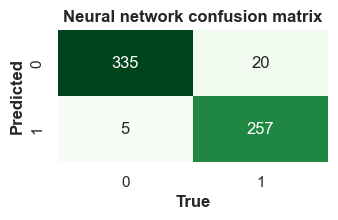

In [198]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False, fmt=".4g")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Neural network confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'NN_conf_matrix.pdf'), format='pdf')
plt.show()

In [199]:
net.model_.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               23200     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 2)                 202       
                                                                 
Total params: 43,602
Trainable params: 43,602
Non-trainable params: 0
_________________________________________________________________


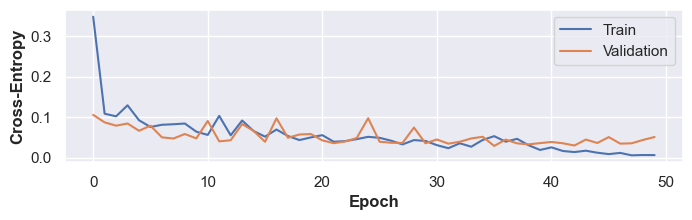

In [200]:
history = net.history_
fig, ax = plt.subplots(figsize=default_style.SHORT_FULLSIZE_FIGURE)
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.savefig(os.path.join(IMAGE_FOLDER, 'NN_Cross_entropy_class.pdf'), format='pdf')
plt.show()

20/20 [==============================] - 0s 3ms/step


C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2752612013.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(IMAGE_FOLDER, 'NN_ROC.pdf'), format='pdf')
C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2752612013.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(IMAGE_FOLDER, 'NN_ROC.pdf'), format='pdf')
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


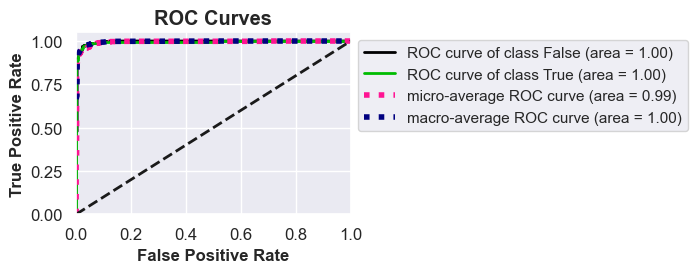

0.9953015804752178


In [201]:
from scikitplot.metrics import plot_roc

y_test_pred_proba = net.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'NN_ROC.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

# Ensemble methods

## Random Forest

In [202]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [203]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 2000, 10)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',['auto', 'sqrt'])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               bootstrap=bootstrap, criterion=criterion)
    rf.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-06 19:35:07,663] A new study created in memory with name: no-name-29049d12-fc86-4bb7-b8cc-7a1258dd84f4
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[W 2023-07-06 19:35:07,747] Trial 4 failed with parameters: {'n_estimators': 1500, 'max_depth': 60, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 10, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'min_samples_split' parameter of RandomForestClassifier must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got 1 instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-pa

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2023-07-06 19:36:13,799] Trial 11 finished with value: 0.9641873278236914 and parameters: {'n_estimators': 1270, 'max_depth': 80, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 6, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.9696969696969697.
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers 

[W 2023-07-06 19:36:49,531] Trial 26 failed with value None.
[W 2023-07-06 19:36:49,630] Trial 27 failed with parameters: {'n_estimators': 1980, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 12, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-pa

[W 2023-07-06 19:36:50,039] Trial 32 failed with value None.
[W 2023-07-06 19:36:50,114] Trial 33 failed with parameters: {'n_estimators': 1960, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 12, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-pa

[W 2023-07-06 19:36:50,503] Trial 38 failed with value None.
[W 2023-07-06 19:36:50,564] Trial 39 failed with parameters: {'n_estimators': 2000, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-pa

[W 2023-07-06 19:36:50,948] Trial 44 failed with value None.
[W 2023-07-06 19:36:51,014] Trial 45 failed with parameters: {'n_estimators': 1850, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 12, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-pa

[I 2023-07-06 19:37:34,296] Trial 20 finished with value: 0.9641873278236914 and parameters: {'n_estimators': 1930, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 7 with value: 0.9696969696969697.
[I 2023-07-06 19:37:34,763] Trial 21 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 1990, 'max_depth': 30, 'max_features': 'auto', 'min_samples_split': 13, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 7 with value: 0.9696969696969697.
[I 2023-07-06 19:37:35,530] Trial 22 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 1980, 'max_depth': 30, 'max_features': 'auto', 'min_samples_split': 12, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 7 with value: 0.9696969696969697.


In [204]:
best_params = study.best_params

rf = RandomForestClassifier(**best_params)
rf.fit(X_res_t, y_res_t)

y_pred_test = rf.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'n_estimators': 1490, 'max_depth': 30, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'}
              precision    recall  f1-score   support

       False       1.00      0.93      0.96       355
        True       0.92      1.00      0.95       262

    accuracy                           0.96       617
   macro avg       0.96      0.96      0.96       617
weighted avg       0.96      0.96      0.96       617

Accuracy 0.9594813614262561
F1-score [0.9636099  0.95429616]


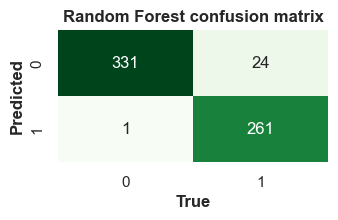

In [205]:
from sklearn.metrics import confusion_matrix

fig,ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False, fmt=".4g")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Random Forest confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_conf_matrix.pdf'), format='pdf')
plt.show()

C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2006122867.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_ROC.pdf'), format='pdf')
C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\2006122867.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_ROC.pdf'), format='pdf')
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


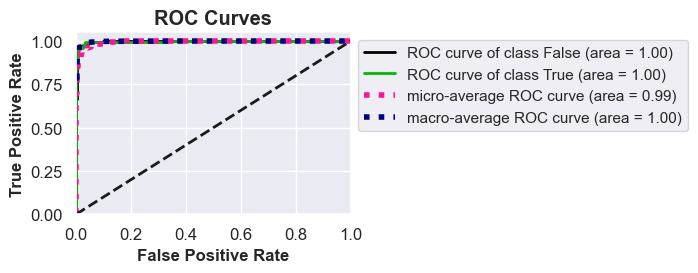

0.9971615955273627


In [206]:
from sklearn.metrics import roc_auc_score

y_test_pred_proba = rf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_ROC.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

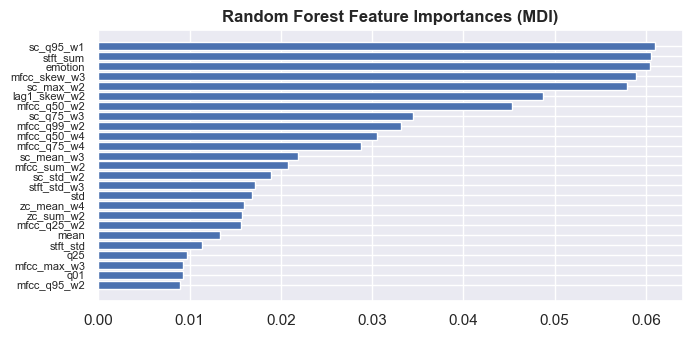

In [220]:
nbr_features = X_res_t.shape[1]

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[::-1][:25]
df2 = df.iloc[:, sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots(figsize=default_style.FULLSIZE_FIGURE)
plt.barh(y_ticks, tree_feature_importances[sorted_idx][::-1])
plt.yticks(y_ticks, list(df2.columns)[::-1], size=8)
plt.title("Random Forest Feature Importances (MDI)")
plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_importance.pdf'), format='pdf')
plt.show()

In [208]:
from sklearn.inspection import permutation_importance

In [209]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

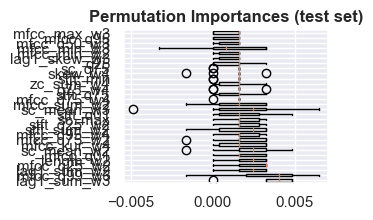

In [210]:
sorted_idx = result.importances_mean.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=list(df2.columns)[::-1])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [211]:
from sklearn.tree import plot_tree

In [212]:
rf.estimators_[0]

DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features='sqrt',
                       min_samples_leaf=7, min_samples_split=9,
                       random_state=1489090675)

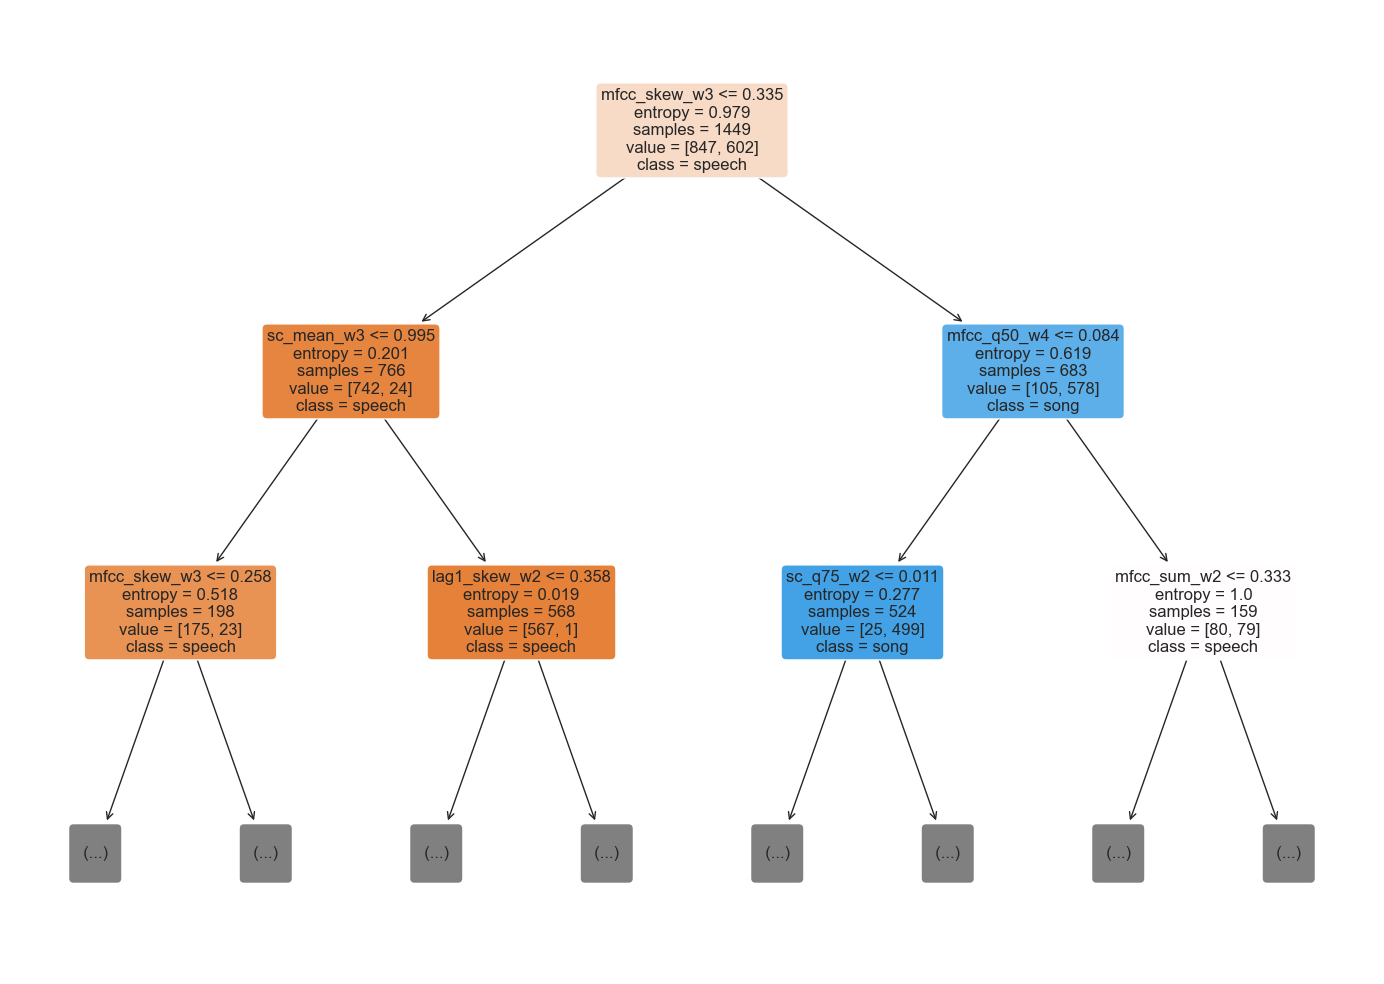

In [213]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[0], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_trees.pdf'), format='pdf')
plt.show()

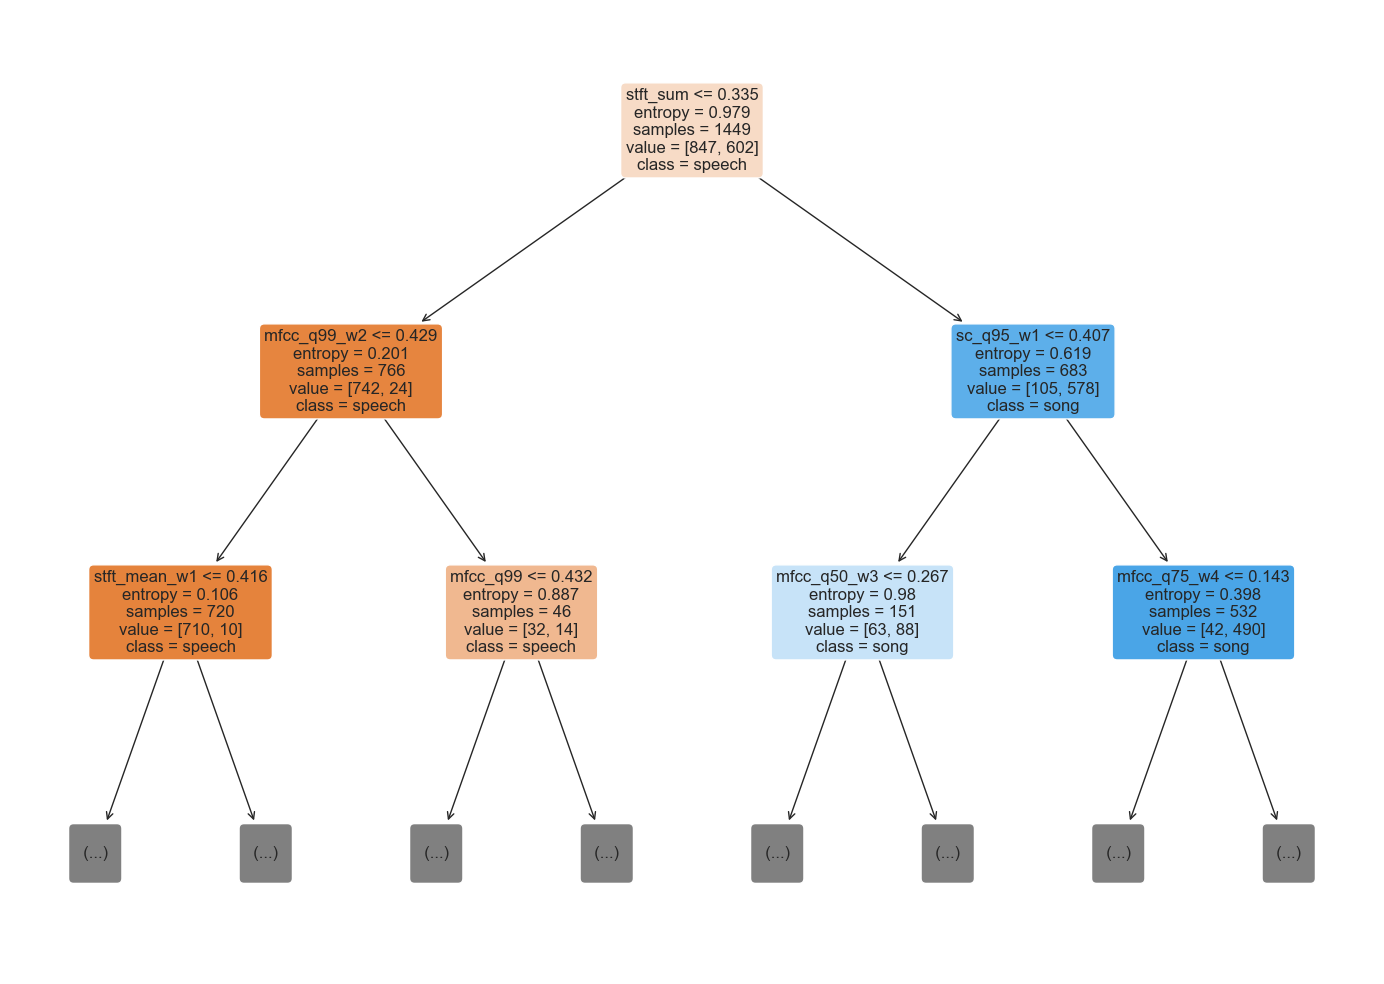

In [214]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[1], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

# Gradient Boosting

In [215]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [224]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 1, 20)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',["log2","sqrt"])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    criterion = trial.suggest_categorical('criterion', ["friedman_mse",  "mae"])
    subsample = trial.suggest_float('subsample', 0.5, 1)
    loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
                                  
                                          
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               learning_rate=learning_rate, criterion=criterion, subsample=subsample, loss=loss)
    gb.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 100, n_jobs = -1, catch=(ValueError,))

[I 2023-07-06 19:48:33,482] A new study created in memory with name: no-name-5896fc0e-bae9-4aa3-a0c1-099663dd64e7
[W 2023-07-06 19:48:33,498] Trial 0 failed with parameters: {'n_estimators': 19, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 10, 'learning_rate': 0.23034823450289185, 'criterion': 'mae', 'subsample': 0.7346494570516997, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages

[W 2023-07-06 19:48:33,584] Trial 10 failed with parameters: {'n_estimators': 15, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 8, 'learning_rate': 0.21213719067383258, 'criterion': 'mae', 'subsample': 0.5650361781239842, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self._validate_params()
  File "C:\Users\emanu\.virtualenvs\DM2-HU

[W 2023-07-06 19:48:35,798] Trial 20 failed with parameters: {'n_estimators': 3, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 9, 'learning_rate': 0.22606691619992106, 'criterion': 'mae', 'subsample': 0.661985125693926, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self._validate_params()
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9

[W 2023-07-06 19:48:36,724] Trial 27 failed with value None.
[I 2023-07-06 19:48:37,592] Trial 17 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 19, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 3, 'learning_rate': 0.25295032620335495, 'criterion': 'friedman_mse', 'subsample': 0.6091191191894918, 'loss': 'deviance'}. Best is trial 6 with value: 0.9696969696969697.
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
[I 2023-07-06 19:48:37,682] Trial 18 finished with value: 0.9696969696969697 and parameters: {'n_estimators': 12, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 8, 'learning_rate': 0.21691266507001555, 'criterion': 'friedman_mse', 'subsample': 0.9926361342

[W 2023-07-06 19:48:37,987] Trial 35 failed with value None.
[W 2023-07-06 19:48:38,048] Trial 36 failed with parameters: {'n_estimators': 8, 'max_depth': 40, 'max_features': 'log2', 'min_samples_split': 1, 'min_samples_leaf': 5, 'learning_rate': 0.22722478421371062, 'criterion': 'mae', 'subsample': 0.5185289199356646, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self

[W 2023-07-06 19:48:38,320] Trial 41 failed with value None.
[W 2023-07-06 19:48:38,369] Trial 42 failed with parameters: {'n_estimators': 8, 'max_depth': 40, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 5, 'learning_rate': 0.2952531783698202, 'criterion': 'mae', 'subsample': 0.5192298524020617, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self.

[W 2023-07-06 19:48:38,648] Trial 47 failed with value None.
[W 2023-07-06 19:48:38,732] Trial 48 failed with parameters: {'n_estimators': 8, 'max_depth': 40, 'max_features': 'log2', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.29750699947472453, 'criterion': 'mae', 'subsample': 0.500984676965448, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self.

[W 2023-07-06 19:48:39,036] Trial 53 failed with value None.
[W 2023-07-06 19:48:39,099] Trial 54 failed with parameters: {'n_estimators': 9, 'max_depth': 40, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 1, 'learning_rate': 0.28897604041203173, 'criterion': 'mae', 'subsample': 0.7014761759348962, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self

[W 2023-07-06 19:48:39,364] Trial 59 failed with value None.
[W 2023-07-06 19:48:39,373] Trial 58 failed with value None.
[W 2023-07-06 19:48:39,466] Trial 60 failed with parameters: {'n_estimators': 20, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 5, 'learning_rate': 0.29728852219982943, 'criterion': 'mae', 'subsample': 0.719880778449815, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-p

[W 2023-07-06 19:48:39,700] Trial 65 failed with value None.
[W 2023-07-06 19:48:39,703] Trial 64 failed with value None.
[W 2023-07-06 19:48:39,766] Trial 66 failed with parameters: {'n_estimators': 20, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 5, 'learning_rate': 0.29660056809299795, 'criterion': 'mae', 'subsample': 0.7290125372474136, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-

[W 2023-07-06 19:48:40,112] Trial 71 failed with value None.
[W 2023-07-06 19:48:40,199] Trial 72 failed with parameters: {'n_estimators': 20, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 5, 'learning_rate': 0.1138022319201015, 'criterion': 'mae', 'subsample': 0.5002038422307882, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self._

[W 2023-07-06 19:48:40,582] Trial 77 failed with value None.
[W 2023-07-06 19:48:40,648] Trial 78 failed with parameters: {'n_estimators': 19, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 5, 'learning_rate': 0.10982650927344986, 'criterion': 'mae', 'subsample': 0.6922758039786839, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self.

[W 2023-07-06 19:48:41,026] Trial 83 failed with value None.
[W 2023-07-06 19:48:41,052] Trial 84 failed with parameters: {'n_estimators': 20, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 5, 'learning_rate': 0.2991587548960969, 'criterion': 'mae', 'subsample': 0.7354070574012113, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self._

[W 2023-07-06 19:48:41,315] Trial 88 failed with value None.
[W 2023-07-06 19:48:41,334] Trial 89 failed with value None.
[W 2023-07-06 19:48:41,416] Trial 90 failed with parameters: {'n_estimators': 20, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 5, 'learning_rate': 0.28602277007176635, 'criterion': 'mae', 'subsample': 0.7201407461766097, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-

[W 2023-07-06 19:48:41,667] Trial 95 failed with value None.
[W 2023-07-06 19:48:41,715] Trial 96 failed with parameters: {'n_estimators': 20, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 5, 'learning_rate': 0.29816304047939446, 'criterion': 'mae', 'subsample': 0.7317624123004429, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self.

In [225]:
best_params = study.best_params

gb = GradientBoostingClassifier(**best_params)
gb.fit(X_res_t, y_res_t)

y_pred_test = gb.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 3, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 3, 'learning_rate': 0.2593398421747558, 'criterion': 'friedman_mse', 'subsample': 0.6463725266169157, 'loss': 'log_loss'}
              precision    recall  f1-score   support

       False       0.95      0.95      0.95       355
        True       0.93      0.93      0.93       262

    accuracy                           0.94       617
   macro avg       0.94      0.94      0.94       617
weighted avg       0.94      0.94      0.94       617

Accuracy 0.9416531604538088
F1-score [0.9494382  0.93103448]


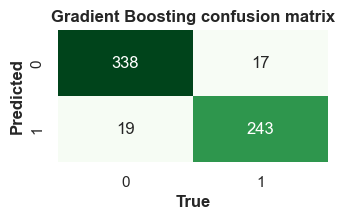

In [226]:
from sklearn.metrics import confusion_matrix

fig,ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', fmt=".4g", cbar=False)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Gradient Boosting confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'GB_conf_matrix.pdf'), format='pdf')
plt.show()

C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3642503946.py:4: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(IMAGE_FOLDER, 'GB_ROC.pdf'), format='pdf')
C:\Users\emanu\AppData\Local\Temp\ipykernel_1008\3642503946.py:4: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(IMAGE_FOLDER, 'GB_ROC.pdf'), format='pdf')
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


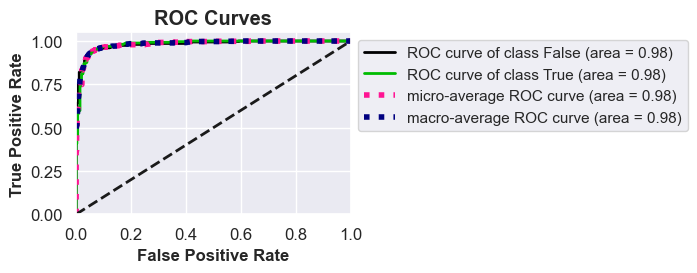

0.9816471347166973


In [227]:
y_test_pred_proba = gb.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'GB_ROC.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))